<a href="https://colab.research.google.com/github/vatsal-ts/Statistical-Analysis-of-DDoS-Attacks/blob/main/result%20notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### imports necessary

In [ ]:
%%capture
!pip install ta
!pip install fathon
!pip install hurst
!pip install mplfinance

In [ ]:
import pandas as pd
import mplfinance as mpf
import plotly.graph_objs as go
import numpy as np
import matplotlib.pyplot as plt
import os
from ta.utils import dropna
import fathon
from fathon import fathonUtils as fu
from scipy.stats import skew
from scipy.stats import kurtosis
from scipy.stats import entropy
from tqdm import tqdm
from hurst import compute_Hc, random_walk
import ta
import time
import pylab

#### drive

In [ ]:
# prompt: mount gdrive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


### proxy functions

In [ ]:
# Define a custom function to get the majority label
def majority_label(series):
    return series.mode()[0] if not series.empty else None

In [ ]:
def convert_to_milli(time_str):
    if time_str[-1] == 'L':
        return float(time_str[:-1])   # Convert milliseconds to microseconds
    elif time_str[-1] == 'S':
        return float(time_str[:-1]) * 1e3  # Convert seconds to microseconds
    else:
        raise ValueError("Invalid time format")

In [ ]:
def resample_to_ohlc(dataframe, higher_granularity,col_to_pick=' Total Fwd Packets'):
    # Ensure Timestamp column is in datetime format
    dataframe.index = pd.to_datetime(dataframe.index)

    # Resample the data to the higher granularity
    resampled_data = dataframe[col_to_pick].resample(higher_granularity)

    # Create an empty DataFrame to store OHLC data
    ohlc_data = pd.DataFrame()

    # Calculate OHLC values manually
    ohlc_data['open'] = resampled_data.first()
    ohlc_data['high'] = resampled_data.max()
    ohlc_data['low'] = resampled_data.min()
    ohlc_data['close'] = resampled_data.last()
    # Filter out zeros before calculating the mean
    # non_zero_resampled_data = resampled_data[resampled_data != 0]
    # ohlc_data['mean'] = non_zero_resampled_data.mean()

    ohlc_data['open']=ohlc_data['open'].shift(1)
    ohlc_data['high']=ohlc_data['high'].shift(1)
    ohlc_data['low']=ohlc_data['low'].shift(1)
    ohlc_data['close']=ohlc_data['close'].shift(1)
    # ohlc_data['mean'] = ohlc_data['mean'].shift(1)
    return ohlc_data

# Create a sample DataFrame with datetime index
date_range = pd.date_range(start='2024-01-01', end='2024-01-10', freq='S')
data = {' Total Fwd Packets': np.random.randint(1, 100, size=len(date_range))}
df = pd.DataFrame(data, index=date_range)

# Call the resample_to_ohlc function
ohlc_data_hourly = resample_to_ohlc(df, '2S')

# print("OHLC Data (Hourly):")
# print(ohlc_data_hourly)


In [ ]:
def plotter(df, df_cols, new_datatime_vline, external_sigs=None, xlabel="TimeStamp", ylabel="Total Fwd Packets", title=None, col_name_proxies={'close':'close','open':'open','high':'high','low':'low'}, double_plot=False, plotly=False):
    if plotly:
        return plotly_plotter(df, df_cols, new_datatime_vline, external_sigs, xlabel, ylabel, title, col_name_proxies, double_plot)
    else:
        return matplotlib_plotter(df, df_cols, new_datatime_vline, external_sigs, xlabel, ylabel, title, col_name_proxies, double_plot)

def plotly_plotter(df, df_cols, new_datatime_vline, external_sigs=None, xlabel="TimeStamp", ylabel="Total Fwd Packets", title=None, col_name_proxies={'close':'close','open':'open','high':'high','low':'low'}, double_plot=False):
    fig = go.Figure()

    # Plot Total Fwd Packets
    fig.add_trace(go.Scatter(x=df.index, y=df[col_name_proxies['close']], mode='lines', name='Total Fwd Packets'))

    # Add vertical line for attack time
    fig.add_vline(x=new_datatime_vline, line=dict(color='black', dash='dash'), name='Attack Time for UDP')

    if double_plot:
        fig.show()

        # Create a new figure for additional plots
        fig = go.Figure()

    # Plot additional columns
    for k in df_cols:
        if df[k].dtype == np.bool_ or str(df[k].dtype) == "bool":
            # Scatter plot for boolean columns
            fig.add_trace(go.Scatter(x=df.index[df[k] == True], y=df[col_name_proxies['close']][df[k] == True], mode='markers', marker=dict(color='red', symbol='triangle-up'), name=k))
        else:
            # Line plot for other columns
            fig.add_trace(go.Scatter(x=df.index, y=df[k], mode='lines', name=k))

    # Add vertical line for attack time if not already added
    fig.add_vline(x=new_datatime_vline, line=dict(color='black', dash='dash'), name='Attack Time for UDP')

    # Update layout
    fig.update_layout(
        xaxis_title=xlabel,
        yaxis_title=ylabel,
        title=title,
        legend=dict(
            orientation="h",
            yanchor="bottom",
            y=1.02,
            xanchor="right",
            x=1
        ),
        hovermode="x"
    )

    return fig

def matplotlib_plotter(df, df_cols, new_datatime_vline, external_sigs=None, xlabel="TimeStamp", ylabel="Total Fwd Packets", title=None, col_name_proxies={'close':'close','open':'open','high':'high','low':'low'}, double_plot=False):
    import matplotlib.pyplot as plt

    # Plot both 'Total Fwd Packets' and Bollinger Bands on the same figure
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df[col_name_proxies['close']], label='Total Fwd Packets', linestyle='-')
    if double_plot:
        plt.axvline(x=new_datatime_vline, color='k', linestyle='--', label='Attack Time for UDP')
        plt.show()
        plt.figure(figsize=(15, 6))
    for k in df_cols:
        if df[k].dtype == np.bool_ or str(df[k].dtype) == "bool":
            plt.scatter(df.index[df[k] == True], df[col_name_proxies['close']][df[k] == True], color='red', marker='^', label=k)
        else:
            plt.plot(df.index, df[k], label=k, linestyle='-')
    plt.axvline(x=new_datatime_vline, color='k', linestyle='--', label='Attack Time for UDP')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.title(title)
    plt.legend()
    plt.grid(True)
    plt.show()


### load dataset

In [ ]:
os.chdir('/content/drive/MyDrive/CICDDoS2019/Dataset/CSVs')

In [ ]:
df0 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/Portmap-training.csv")
df1 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/NetBIOS-training.csv")
df2 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/LDAP-training.csv")
df3 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/MSSQL-training.csv")
df4 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/UDP-training.csv")
df5 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/UDPLag-training.csv")
df6 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/Syn-training.csv")
# dft0 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/Portmap-testing.csv")
dft1 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/NetBIOS-testing.csv")
dft2 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/LDAP-testing.csv")
dft3 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/MSSQL-testing.csv")
dft4 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/UDP-testing.csv")
dft5 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/UDPLag-testing.csv")
dft6 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/Syn-testing.csv")

<ipython-input-12-1d3738e04516>:1: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df0 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/Portmap-training.csv")
<ipython-input-12-1d3738e04516>:2: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df1 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/NetBIOS-training.csv")
<ipython-input-12-1d3738e04516>:3: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df2 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/LDAP-training.csv")
<ipython-input-12-1d3738e04516>:4: DtypeWarning: Columns (85) have mixed types. Specify dtype option on import or set low_memory=False.
  df3 = pd.read_csv("/content/drive/MyDrive/kaggle/input/cicddos2019/MSSQL-training.csv")
<ipython-input-12-1d3738e04516>:5: DtypeWarning: Columns (85) have mixed types. Specify dtype

In [ ]:
combined_df_train = pd.concat([df0, df1, df2, df3, df4, df5, df6], ignore_index=True)
combined_df_test = pd.concat([dft1, dft2, dft3, dft4, dft5, dft6], ignore_index=True)

In [ ]:
df=df4

In [ ]:
print("Value Counts\n\n",df[" Label"].value_counts(),"\n\n")
print("Destination IP Counts\n\n",df[" Destination IP"].value_counts() , "\n\nSource IP counts\n\n",df[" Source IP"].value_counts())

Value Counts

  Label
UDP       28024
BENIGN     3134
MSSQL       182
Name: count, dtype: int64 


Destination IP Counts

  Destination IP
192.168.50.4       28200
4.2.2.4              630
192.168.50.9         355
172.105.219.195      215
192.168.50.8         139
                   ...  
91.189.89.199          1
8.43.72.21             1
91.189.91.157          1
224.0.0.22             1
239.255.255.250        1
Name: count, Length: 162, dtype: int64 

Source IP counts

  Source IP
172.16.0.5         28200
192.168.50.8         821
192.168.50.9         795
192.168.50.6         781
172.105.219.195      128
                   ...  
52.1.142.68            1
34.196.124.36          1
52.41.78.152           1
34.216.156.21          1
172.217.6.225          1
Name: count, Length: 143, dtype: int64


In [ ]:
df_test = df[[" Source IP"," Source Port"," Destination IP"," Destination Port"," Timestamp"," Total Fwd Packets"," Label"]]
columns_left = df.columns.difference(df_test.columns)
# print("columns yet to test: " + str(columns_left))

# Convert 'Timestamp' column to datetime
df_test[' Timestamp'] = pd.to_datetime(df_test[' Timestamp'])

# df_test

<ipython-input-16-2467d7383d9d>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test[' Timestamp'] = pd.to_datetime(df_test[' Timestamp'])


In [ ]:
df_test = df_test[df_test[" Destination IP"] == "192.168.50.4"]
# df_test

In [ ]:
aggregation_functions={
    ' Source IP': majority_label,
    ' Source Port': majority_label,
    ' Destination IP': majority_label,
    ' Total Fwd Packets': 'sum',
    ' Destination Port': majority_label,
    ' Label': majority_label,
}

In [ ]:
df_test.columns

Index([' Source IP', ' Source Port', ' Destination IP', ' Destination Port',
       ' Timestamp', ' Total Fwd Packets', ' Label'],
      dtype='object')

In [ ]:
grouped_resampled_df = df_test.groupby(' Destination IP').resample('1L', on=' Timestamp').sum()

# Total count of unique 'Destination IP' in the grouped and resampled DataFrame
total_destination_ip_grouped = grouped_resampled_df.index.get_level_values(' Destination IP').nunique()
print("Total Destination IP in the grouped and resampled DataFrame:", total_destination_ip_grouped)

# grouped_resampled_df

Total Destination IP in the grouped and resampled DataFrame: 1


In [ ]:
print(df_test.groupby(' Destination IP').resample('1L', on=' Timestamp').sum())

                                          Source IP   Source Port  \
 Destination IP  Timestamp                                          
192.168.50.4    2018-11-03 10:42:57.177  172.16.0.5          9413   
                2018-11-03 10:42:57.178           0             0   
                2018-11-03 10:42:57.179  172.16.0.5          9425   
                2018-11-03 10:42:57.180           0             0   
                2018-11-03 10:42:57.181           0             0   
...                                             ...           ...   
                2018-11-03 11:01:43.602           0             0   
                2018-11-03 11:01:43.603           0             0   
                2018-11-03 11:01:43.604           0             0   
                2018-11-03 11:01:43.605           0             0   
                2018-11-03 11:01:43.606  172.16.0.5         33527   

                                         Destination IP   Destination Port  \
 Destination IP  Timesta

In [ ]:
# Filter DataFrame for a particular 'Destination IP' from the grouped and resampled DataFrame
destination_ip_to_filter_grouped = '192.168.50.4'
df_filtered_grouped = grouped_resampled_df.loc[destination_ip_to_filter_grouped]

print("\nDataFrame for Destination IP", destination_ip_to_filter_grouped, ":\n")

df_filtered_grouped


DataFrame for Destination IP 192.168.50.4 :



Source IP   Source Port  Destination IP  \
 Timestamp                                                          
2018-11-03 10:42:57.177  172.16.0.5          9413    192.168.50.4   
2018-11-03 10:42:57.178           0             0               0   
2018-11-03 10:42:57.179  172.16.0.5          9425    192.168.50.4   
2018-11-03 10:42:57.180           0             0               0   
2018-11-03 10:42:57.181           0             0               0   
...                             ...           ...             ...   
2018-11-03 11:01:43.602           0             0               0   
2018-11-03 11:01:43.603           0             0               0   
2018-11-03 11:01:43.604           0             0               0   
2018-11-03 11:01:43.605           0             0               0   
2018-11-03 11:01:43.606  172.16.0.5         33527    192.168.50.4   

                          Destination Port   Total Fwd Packets  Label  
 Timestamp                                                             
2018-11-03 10:42:57.177              20325                   2  MSSQL  
2018-11-03 10:42:57.178                  0                   0      0  
2018-11-03 10:42:57.179              13027                   2  MSSQL  
2018-11-03 10:42:57.180                  0                   0      0  
2018-11-03 10:42:57.181                  0                   0      0  
...                                    ...                 ...    ...  
2018-11-03 11:01:43.602                  0                   0      0  
2018-11-03 11:01:43.603                  0                   0      0  
2018-11-03 11:01:43.604                  0                   0      0  
2018-11-03 11:01:43.605                  0                   0      0  
2018-11-03 11:01:43.606              22951                   2    UDP  

[1126430 rows x 6 columns]

In [ ]:
resampled_df_seconds = df_filtered_grouped[[' Total Fwd Packets']].resample('2S').sum()

In [ ]:
# # Calculate the mean and standard deviation of 'Total Fwd Packets'
mean_packets = resampled_df_seconds[' Total Fwd Packets'].mean()
std_packets = resampled_df_seconds[' Total Fwd Packets'].std()

# Define a threshold based on the mean and standard deviation (e.g., 3 standard deviations away from the mean)
threshold = mean_packets + 3 * std_packets

# Filter out the outliers
filtered_df = resampled_df_seconds[resampled_df_seconds[' Total Fwd Packets'] < threshold]

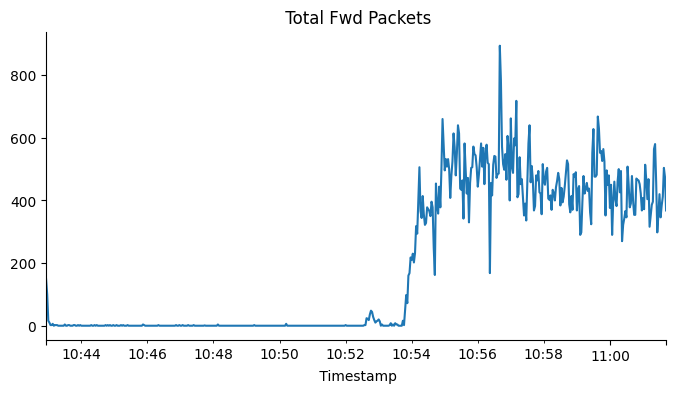

In [ ]:
resampled_df_seconds[' Total Fwd Packets'].plot(kind='line', figsize=(8, 4), title=' Total Fwd Packets')
plt.gca().spines[['top', 'right']].set_visible(False)

### Main runners

#### selecting time quantum to operate on

In [ ]:
def indicator_computation(dfyo_main,resampler_quantum=None,col_name_proxies={'close':'close','open':'open','high':'high','low':'low'}):
  if resampler_quantum:
    dfyo = dfyo_main[[col_name_proxies['close']]].resample(resampler_quantum).sum()
  start_time = time.time()
  # # Calculate the mean and standard deviation of 'Total Fwd Packets'
  mean_packets = dfyo[col_name_proxies['close']].mean()
  std_packets = dfyo[col_name_proxies['close']].std()
  # Retrieve the date from the original timestamp

  # Create a new datetime object with the given time (9:08:11)
  # Define a threshold based on the mean and standard deviation (e.g., 3 standard deviations away from the mean)
  threshold = mean_packets + 3 * std_packets

  # Filter out the outliers
  filtered_df = dfyo
  # filtered_df = dfyo[dfyo[col_name_proxies['close']] < threshold]
  date_part = filtered_df[filtered_df.index.time >= pd.to_datetime('10:53').time()].index[0].date()
  new_datetime = pd.to_datetime(str(date_part) + ' 10:53:00')


  # Initialize Bollinger Bands Indicator
  indicator_bb = ta.volatility.BollingerBands(filtered_df[col_name_proxies['close']],window=50,window_dev=4,fillna=True)
  kst_thing=ta.trend.KSTIndicator(filtered_df[col_name_proxies['close']],fillna=True)
  ema=ta.trend.EMAIndicator(filtered_df[col_name_proxies['close']],fillna=True)
  stcIndic=ta.trend.STCIndicator(filtered_df[col_name_proxies['close']],fillna=True)
  trix=ta.trend.TRIXIndicator(filtered_df[col_name_proxies['close']],fillna=True)
  # ta.trend.VortexIndicator
  # Add Bollinger Bands features
  filtered_df['bb_bbm'] = indicator_bb.bollinger_mavg()
  filtered_df['bb_bbh'] = indicator_bb.bollinger_hband()
  filtered_df['bb_bbl'] = indicator_bb.bollinger_lband()
  filtered_df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
  filtered_df['bb_bbhi'] = filtered_df['bb_bbhi'].astype(bool)
  filtered_df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()
  filtered_df['bb_bbli'] = filtered_df['bb_bbli'].astype(bool)
  filtered_df['kst'] = kst_thing.kst()
  filtered_df['kst_diff'] = kst_thing.kst_diff()
  filtered_df['kst_sig'] = kst_thing.kst_sig()
  filtered_df['ema']=ema.ema_indicator()
  filtered_df['stc']=stcIndic.stc()
  filtered_df['trix']=trix.trix()


  ##Normalising

  # Calculate the range of Bollinger Bands
  bb_range = filtered_df['bb_bbh'] - filtered_df['bb_bbl']

  # Normalize 'KST' between Bollinger Bands
  normalized_kst = (filtered_df['kst'] - filtered_df['bb_bbl']) / bb_range
  # Normalize 'KST Diff' between Bollinger Bands
  normalized_kst_diff = (filtered_df['kst_diff'] - filtered_df['bb_bbl']) / bb_range
  # Normalize 'KST Sig' between Bollinger Bands
  normalized_kst_sig = (filtered_df['kst_sig'] - filtered_df['bb_bbl']) / bb_range
  end_time = time.time()

  return new_datetime,filtered_df,end_time-start_time

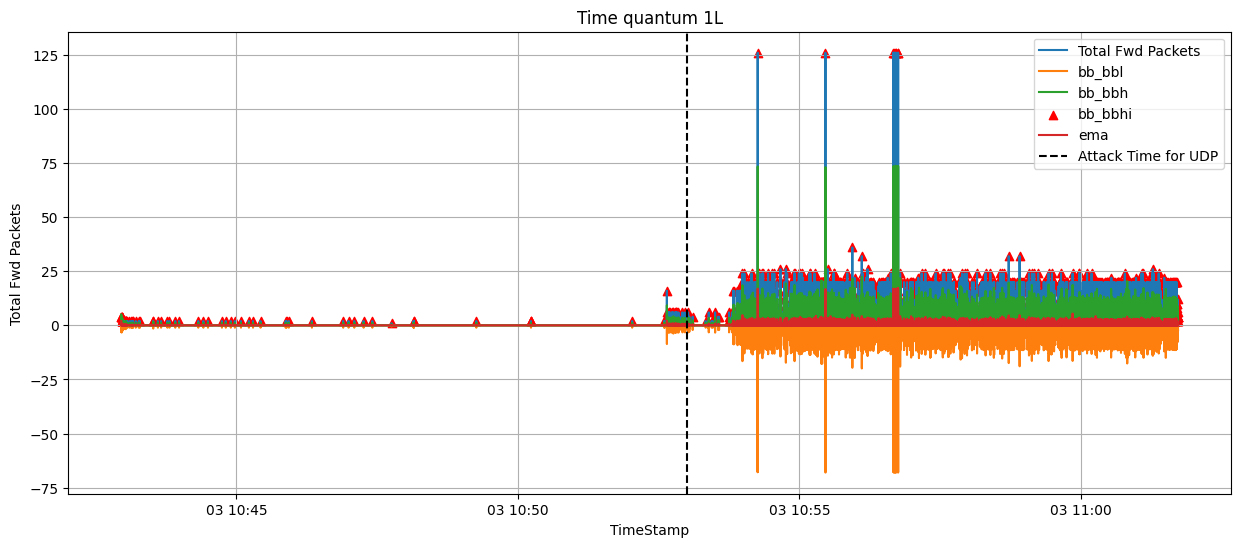

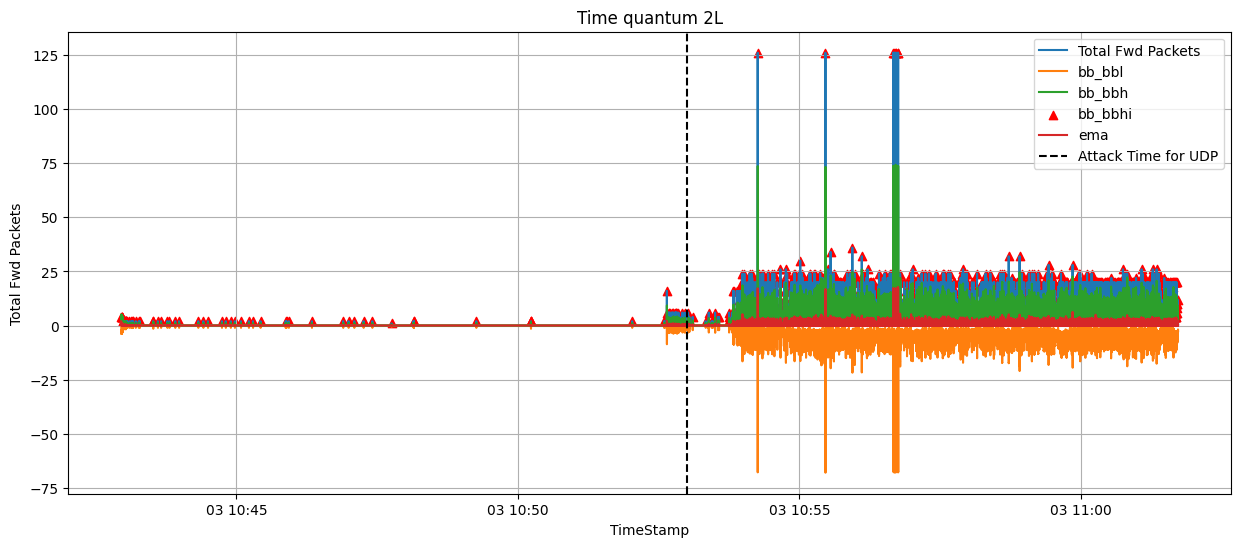

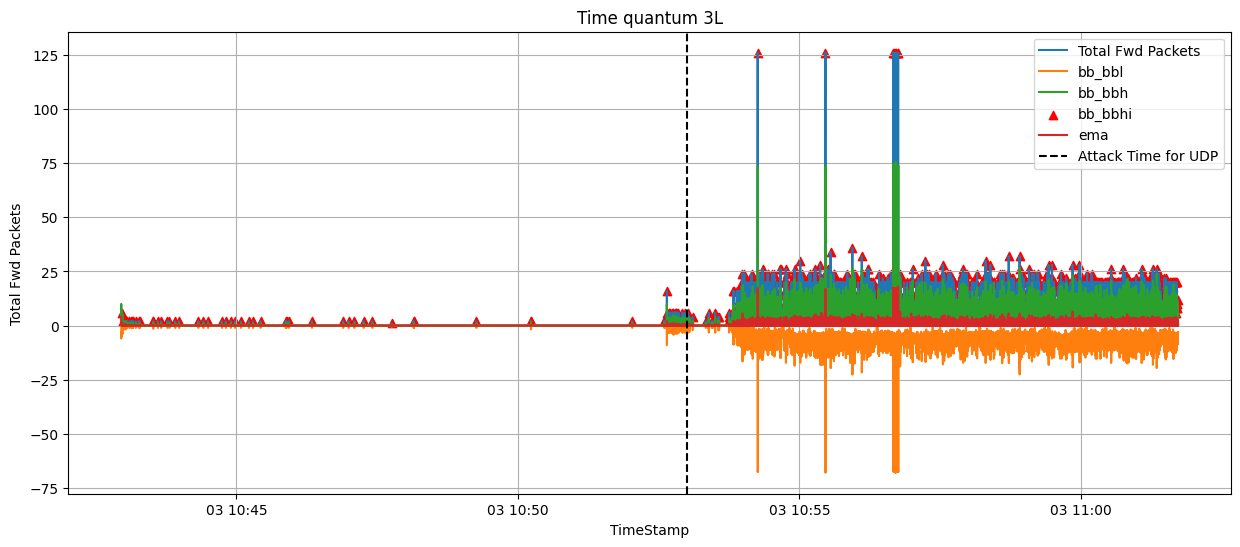

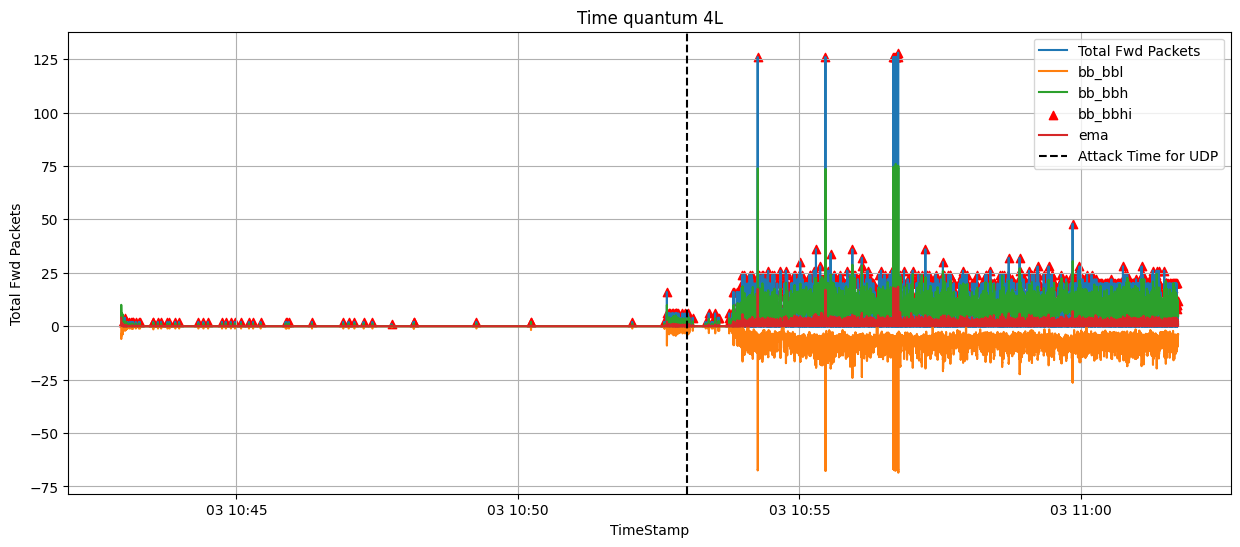

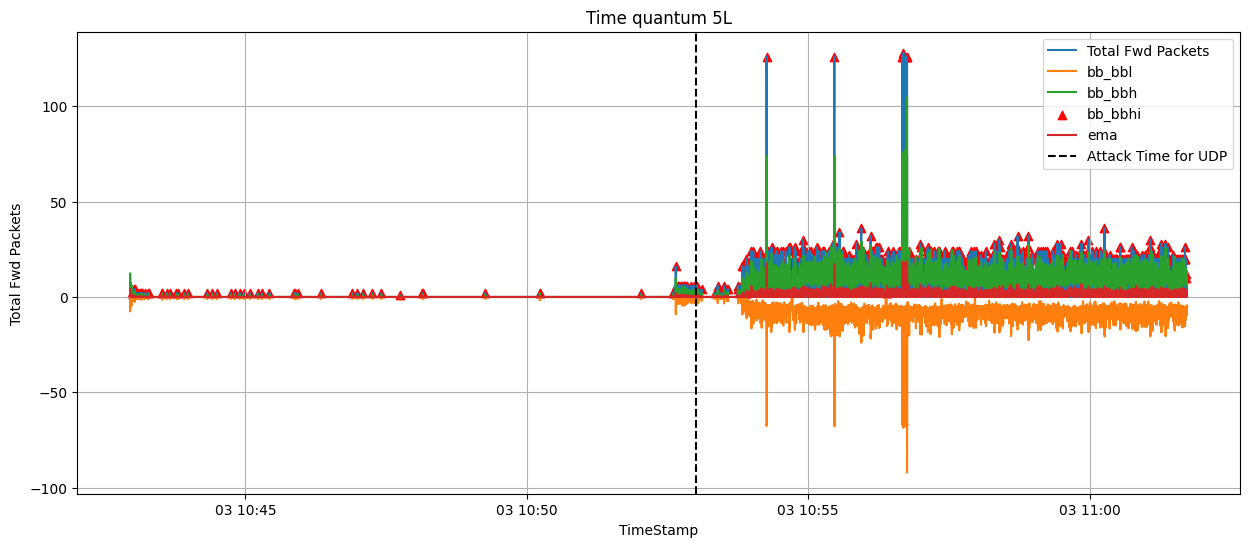

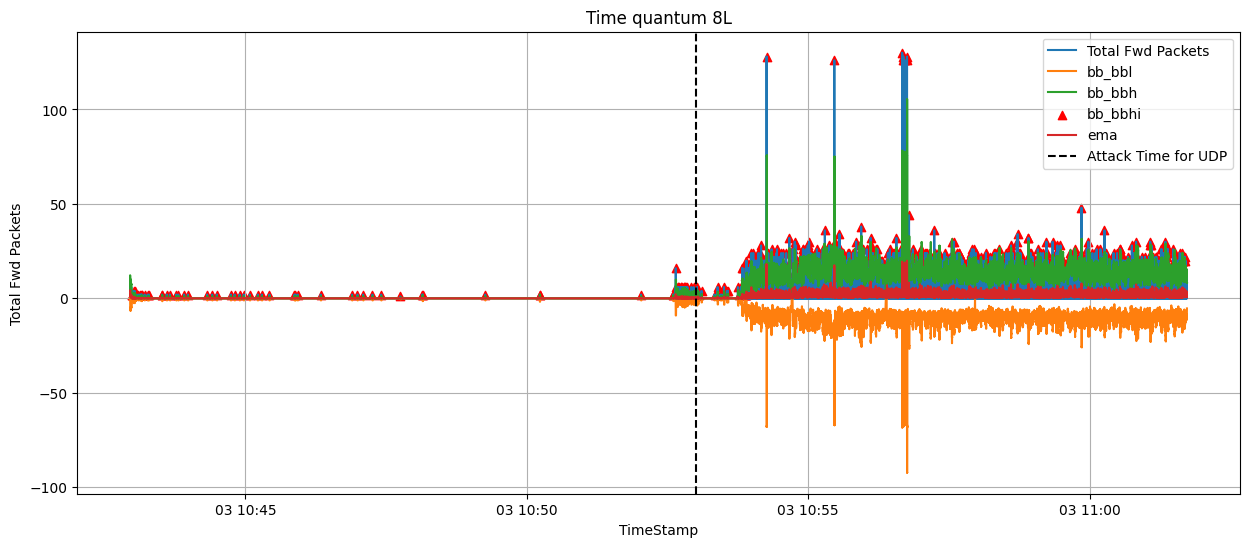

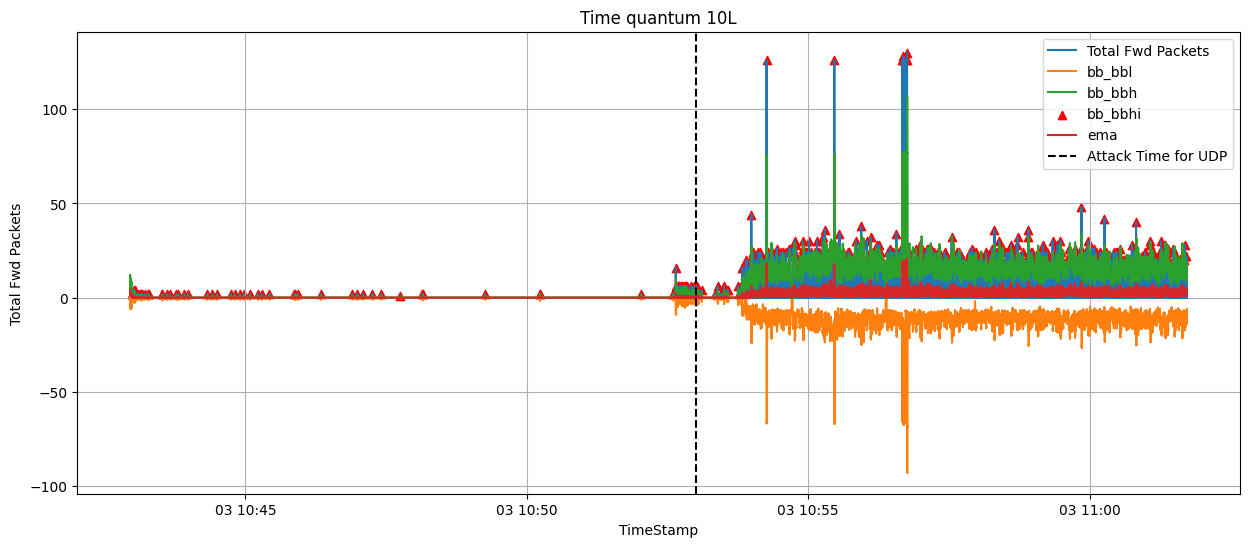

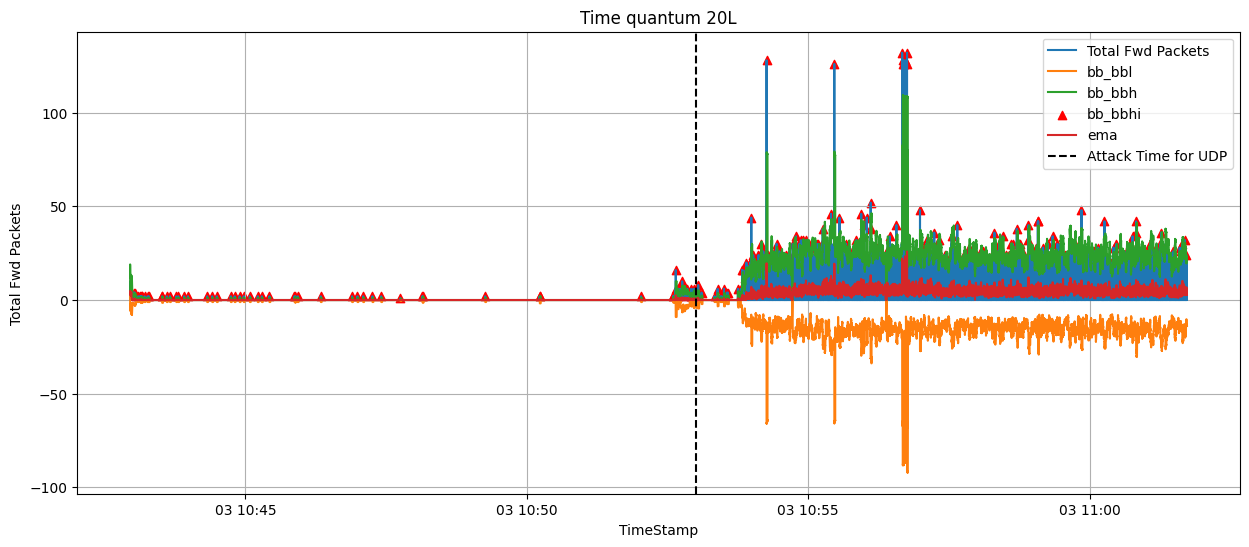

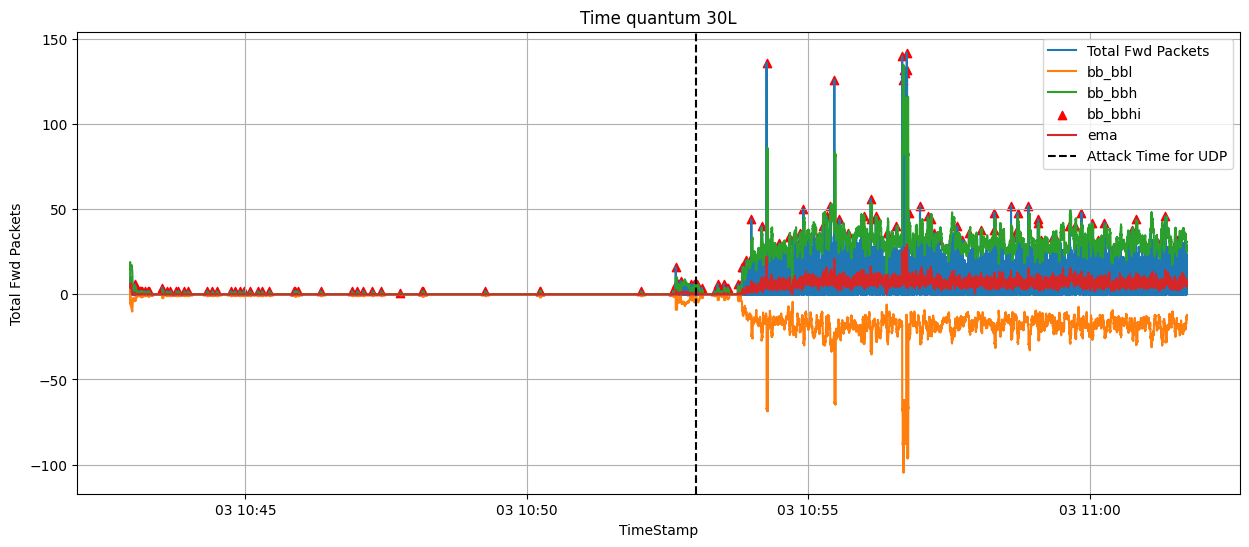

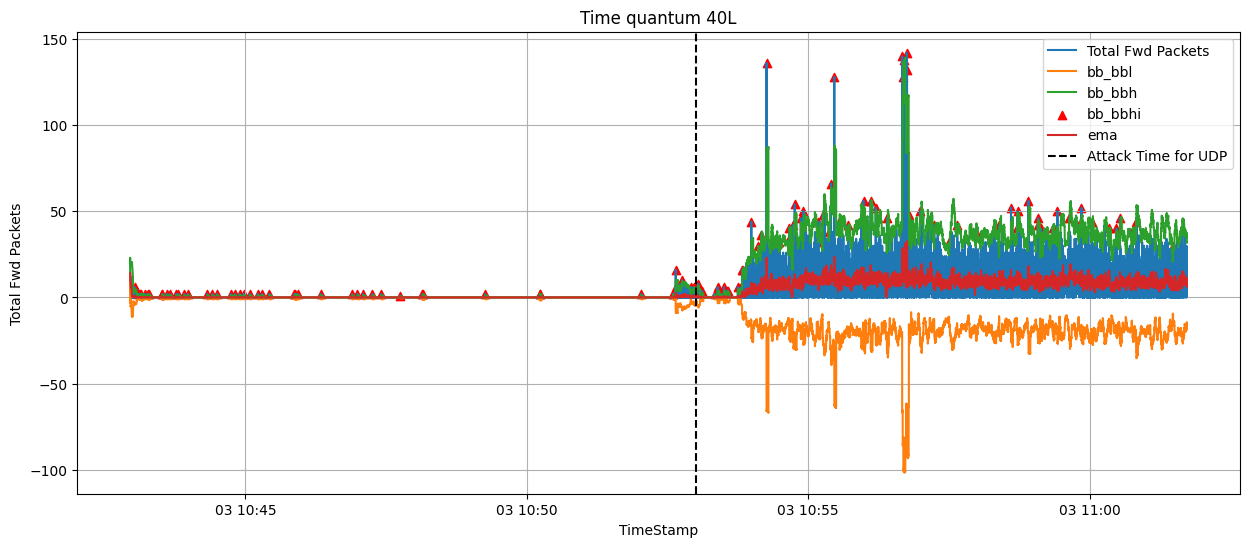

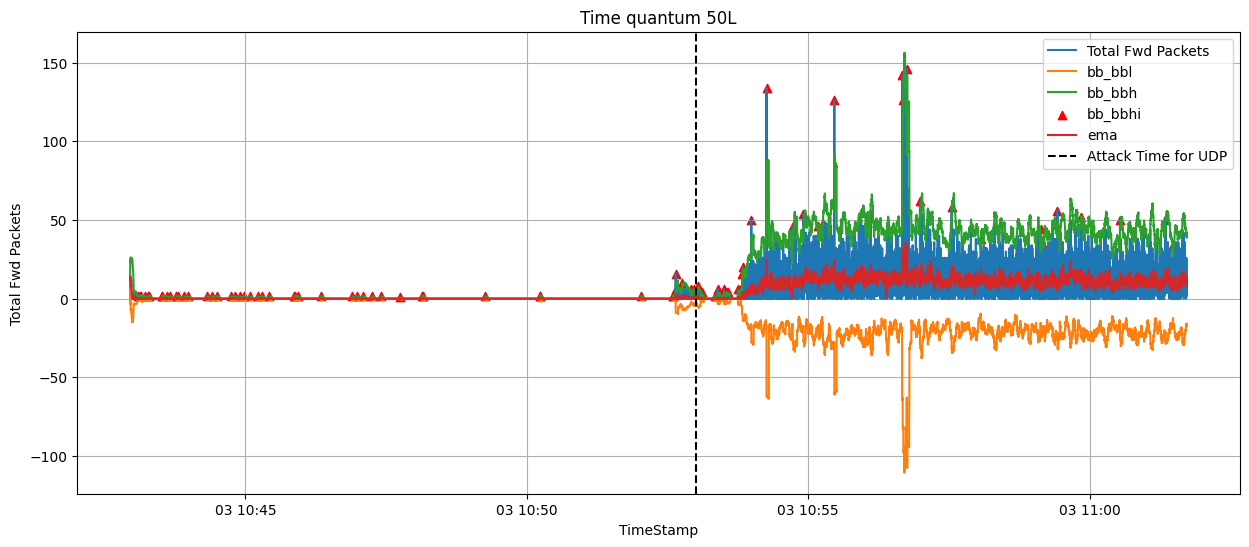

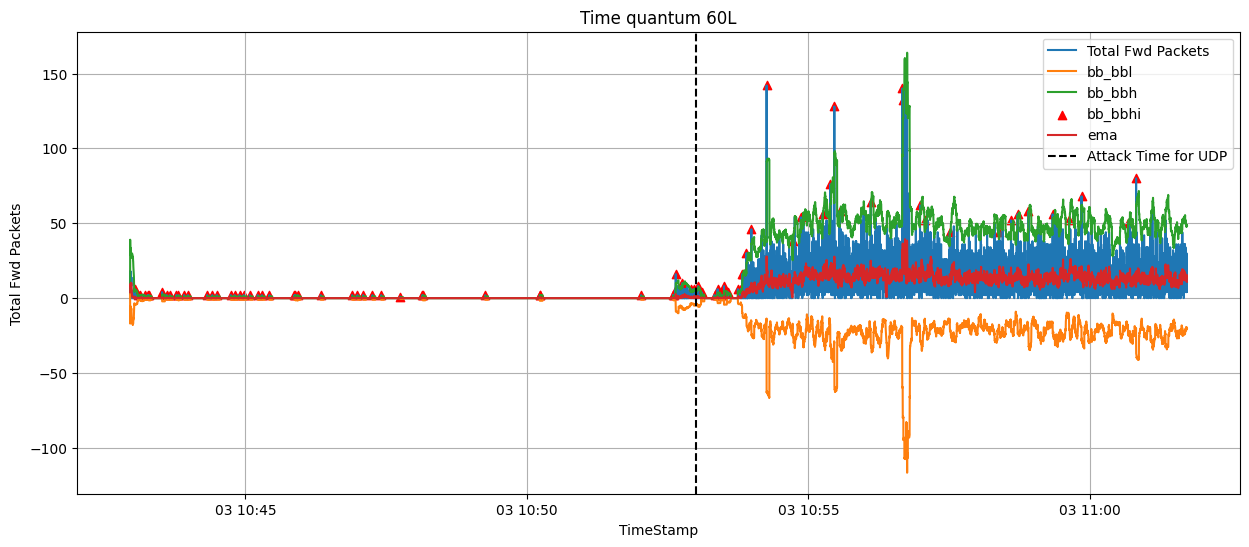

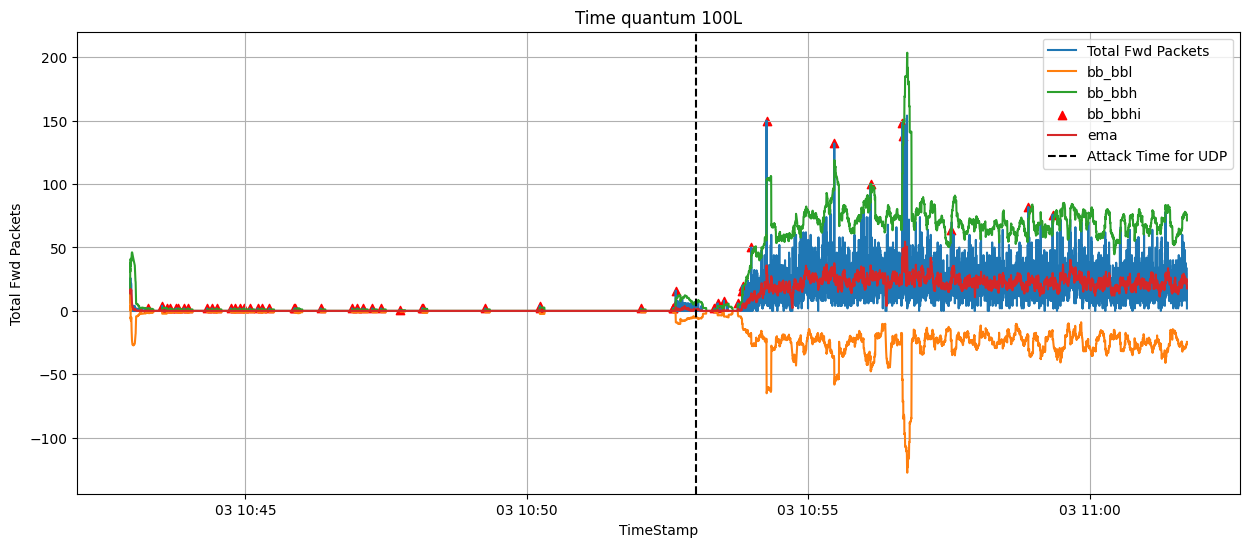

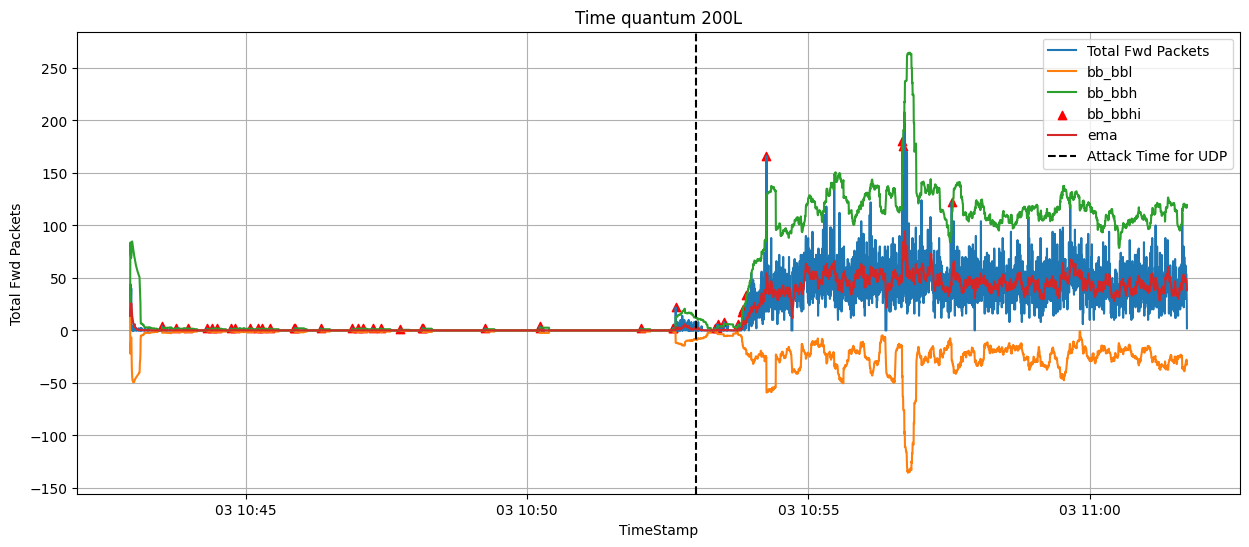

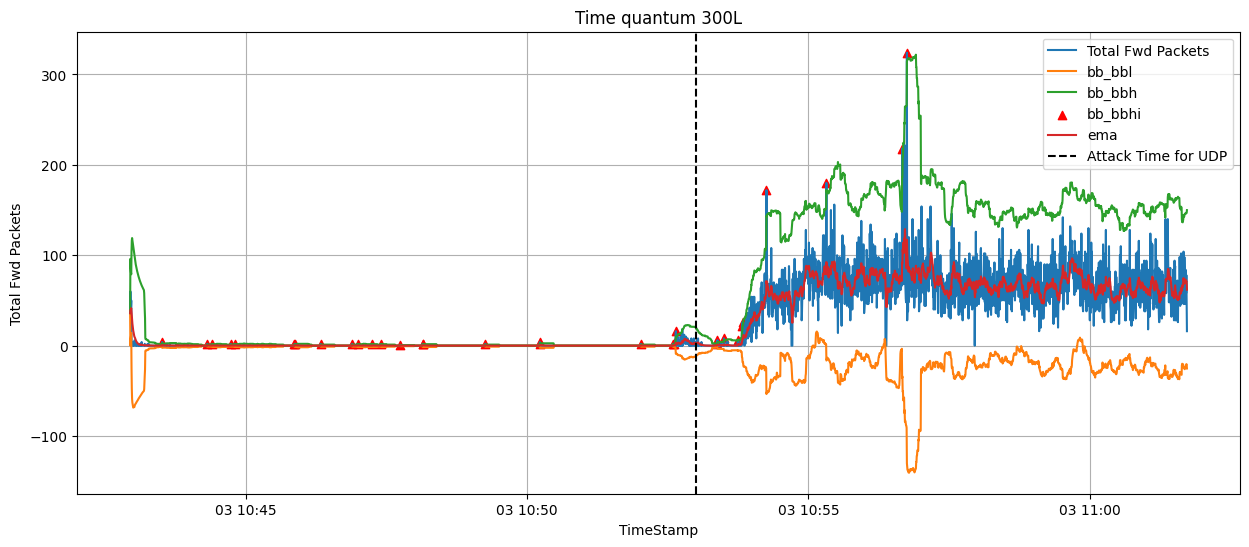

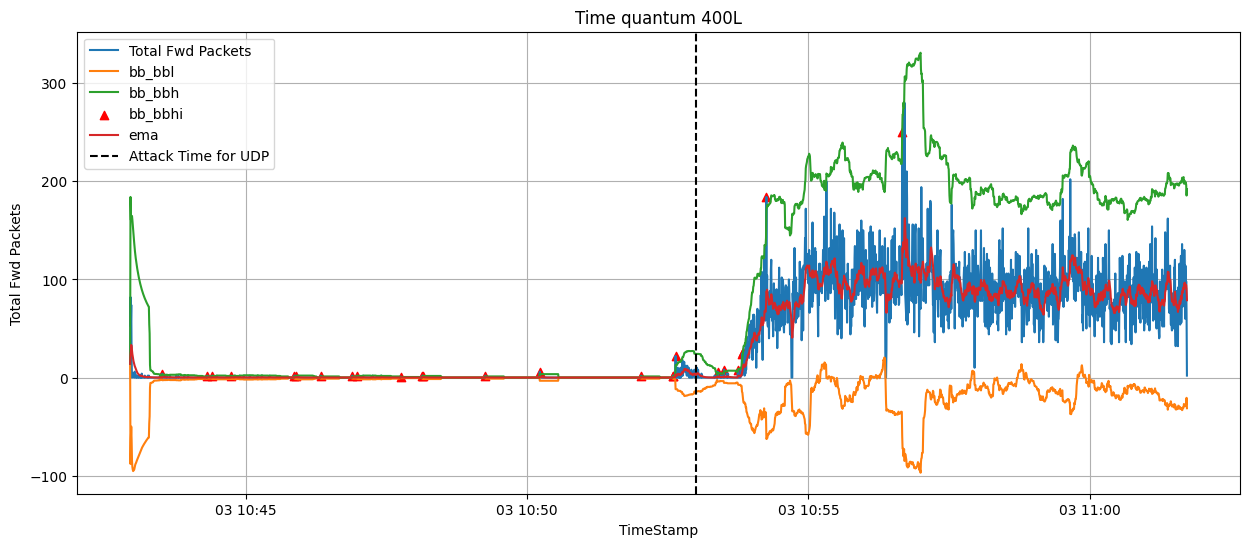

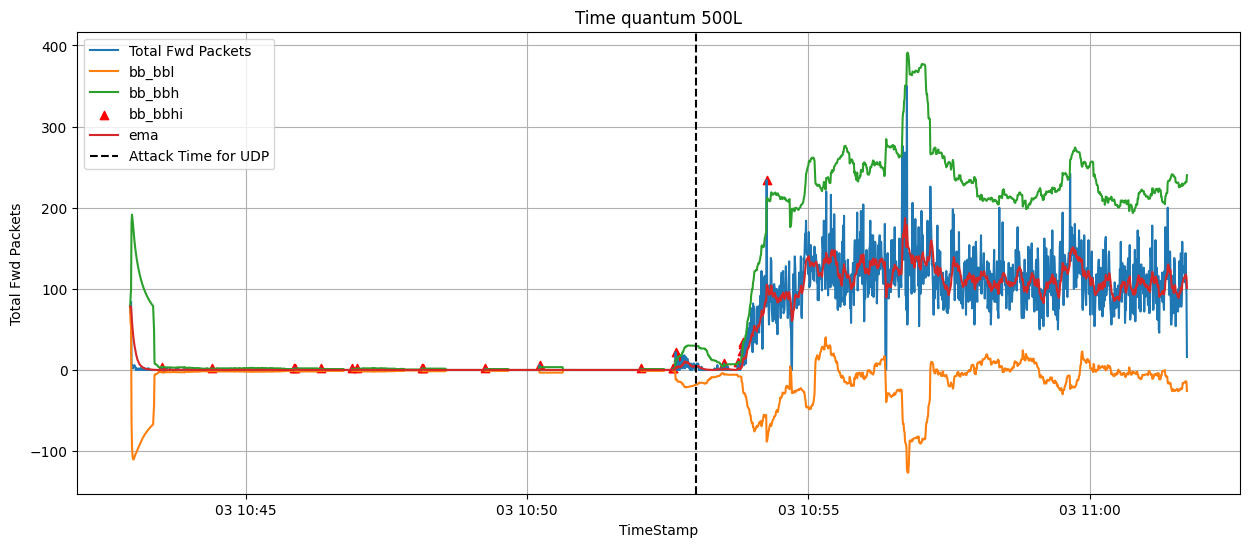

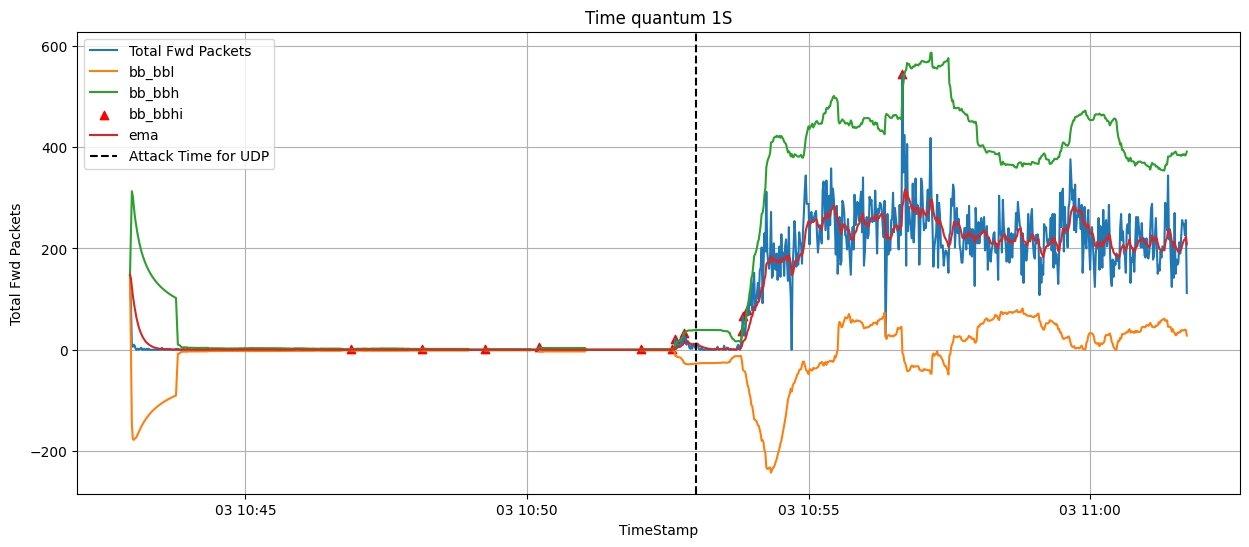

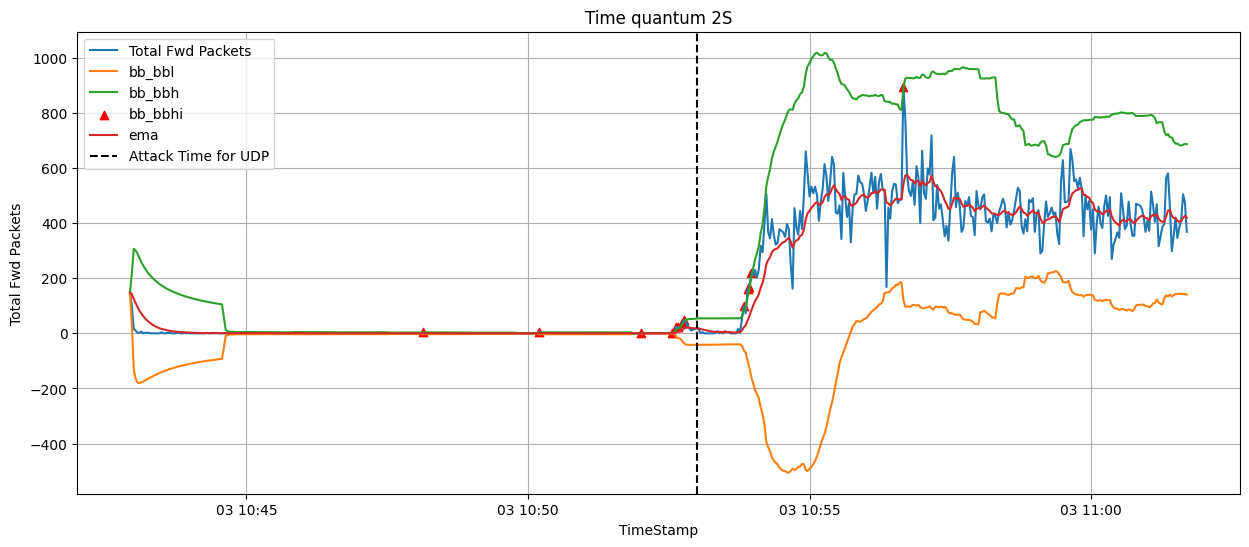

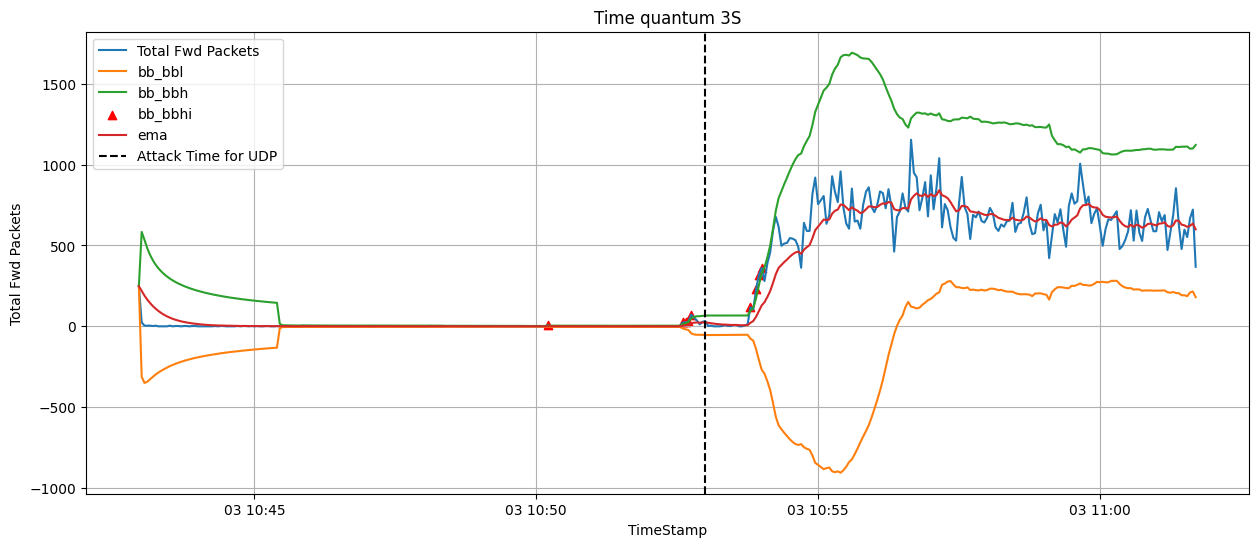

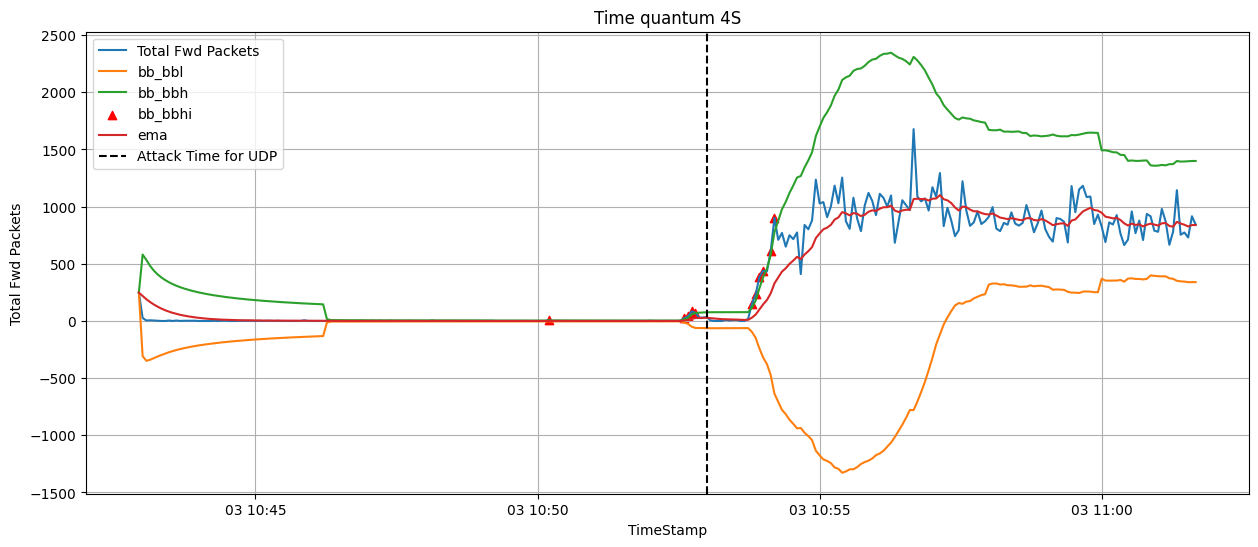

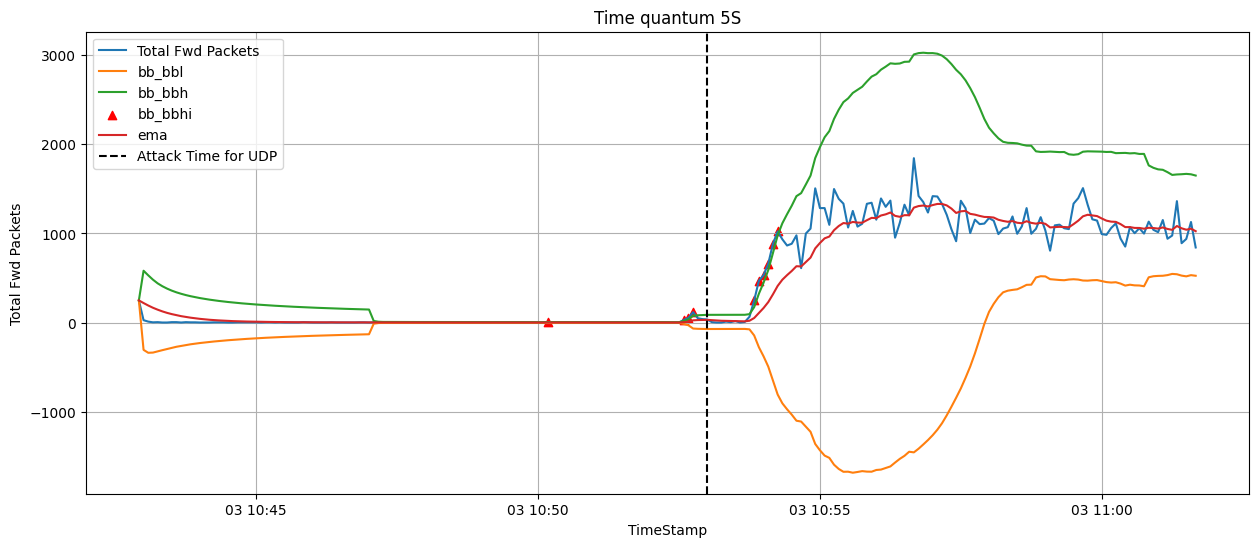

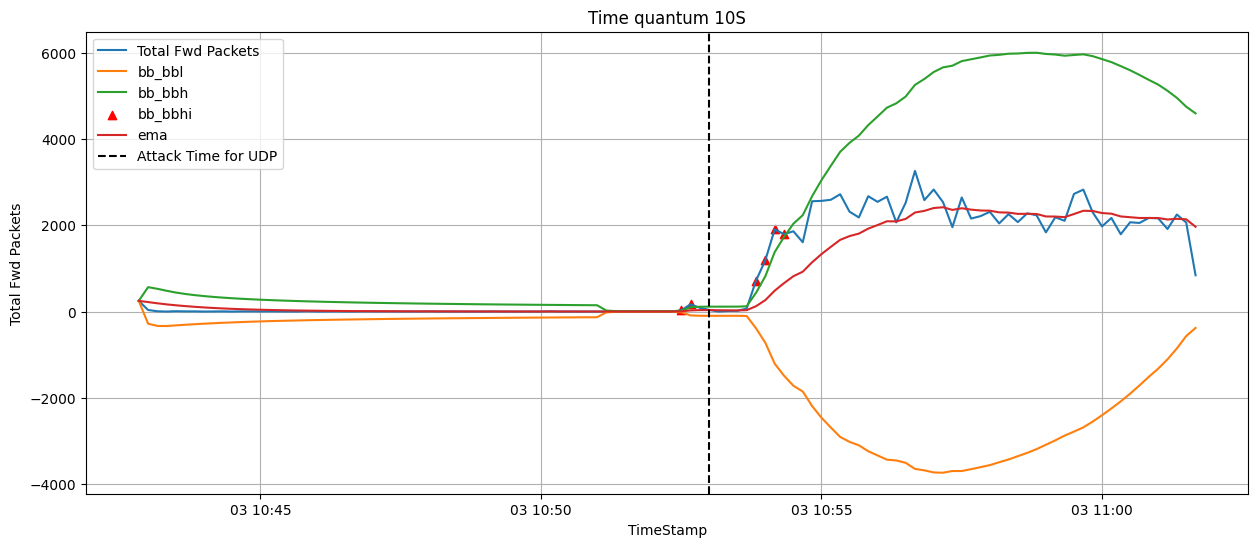

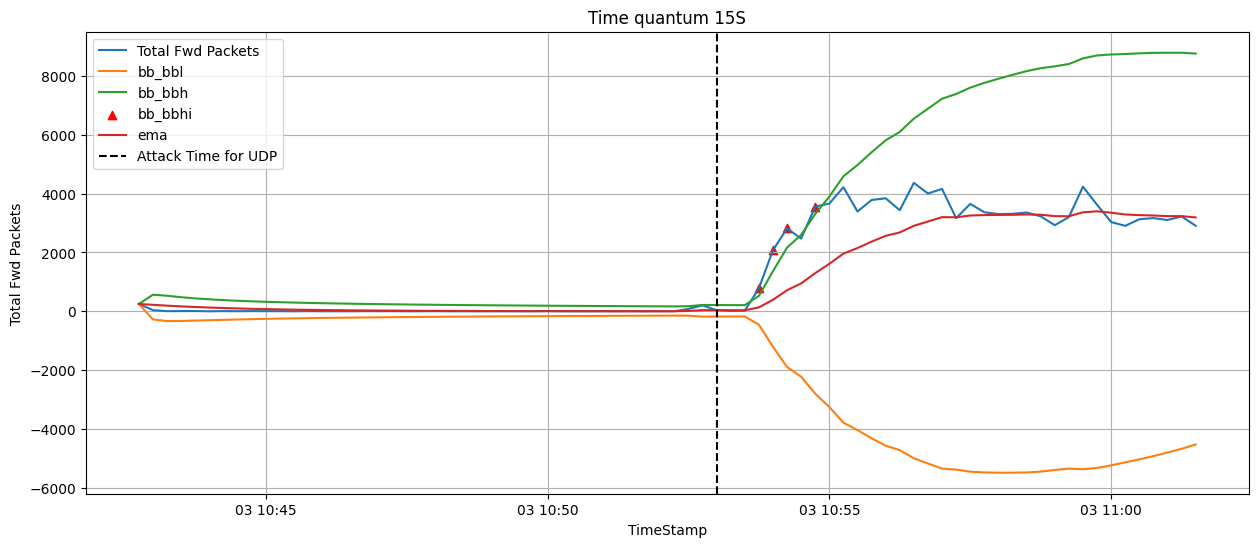

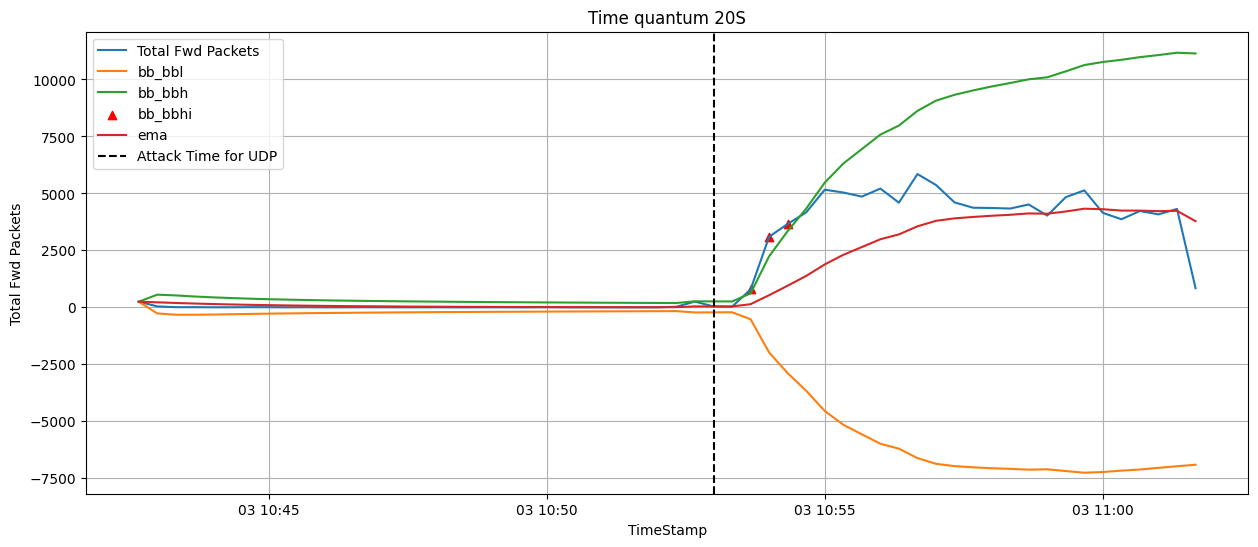

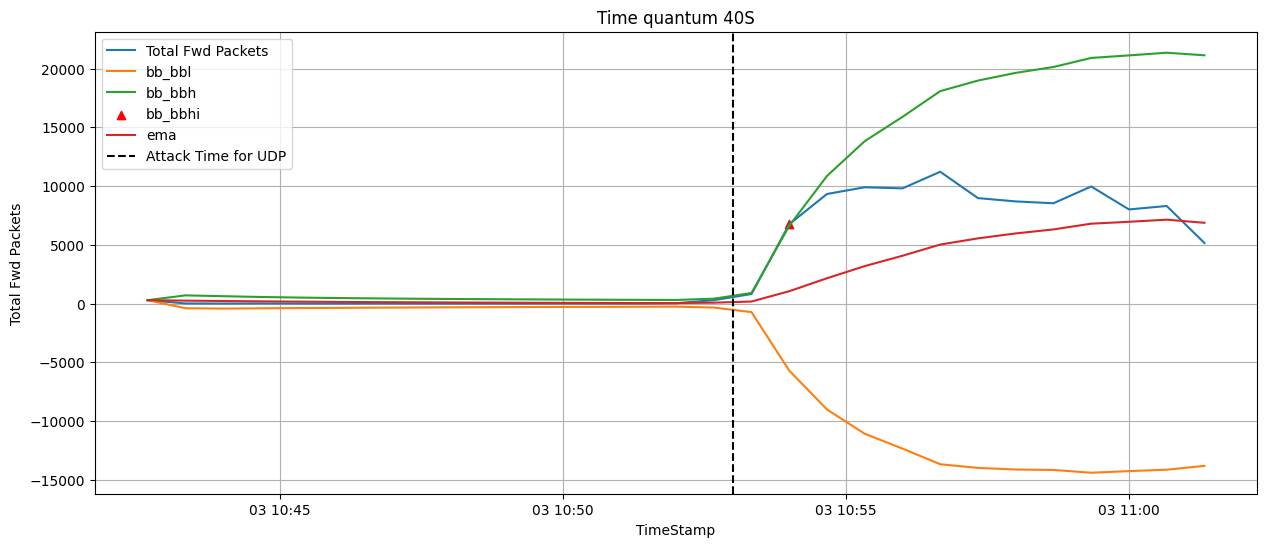

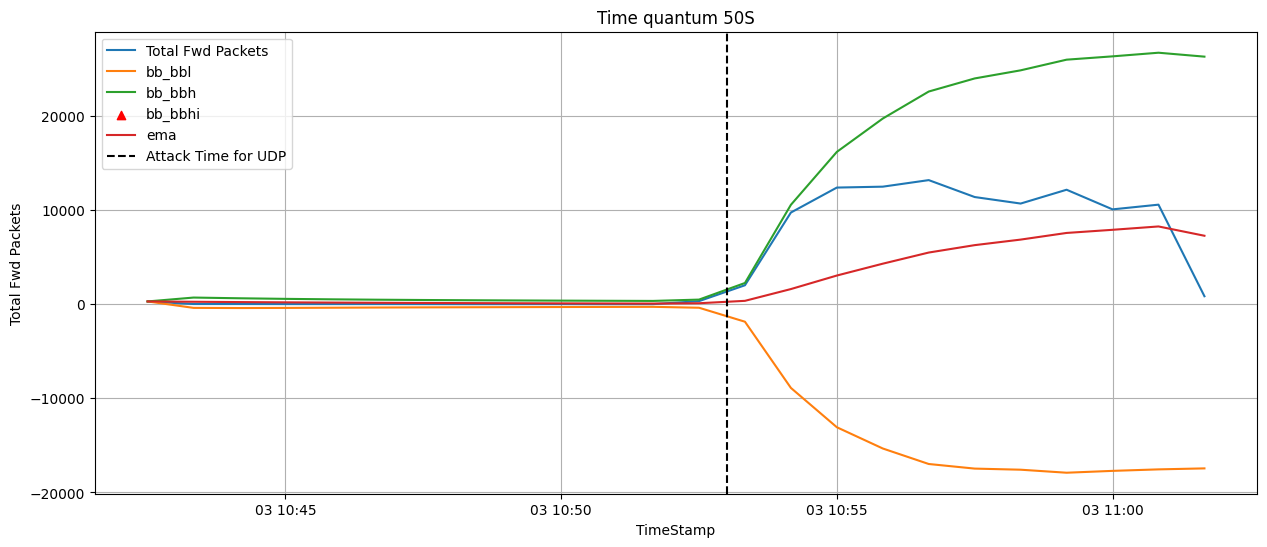

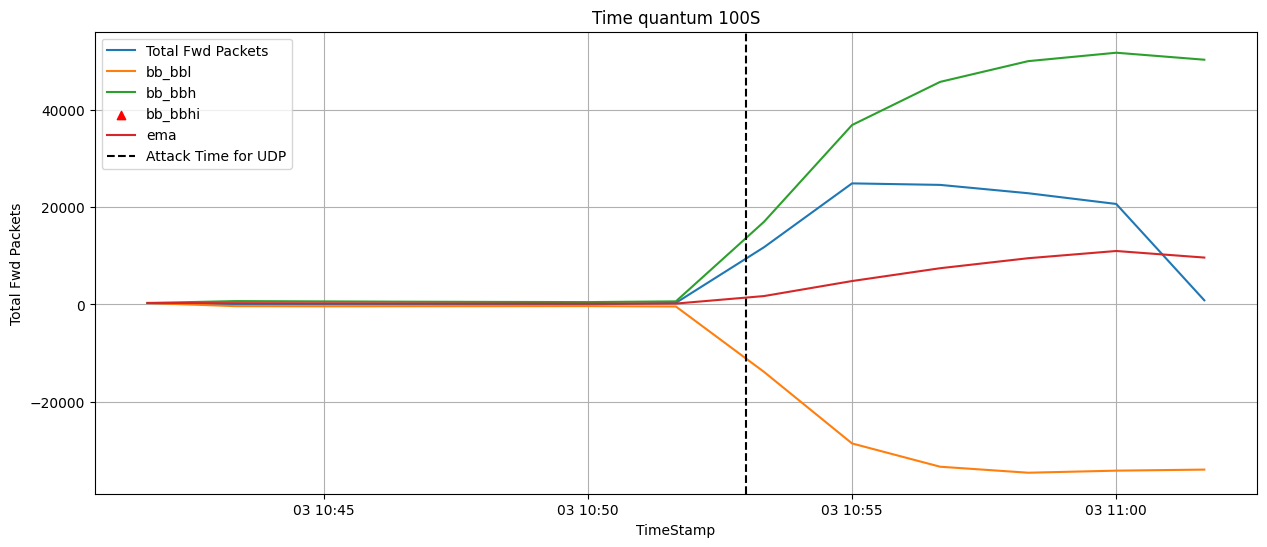

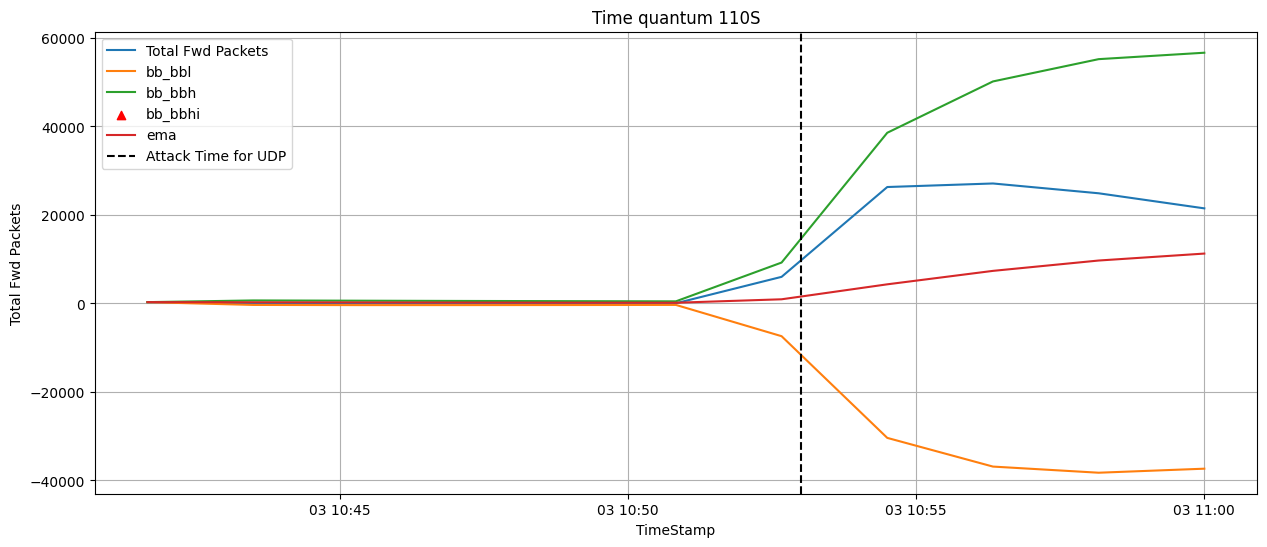

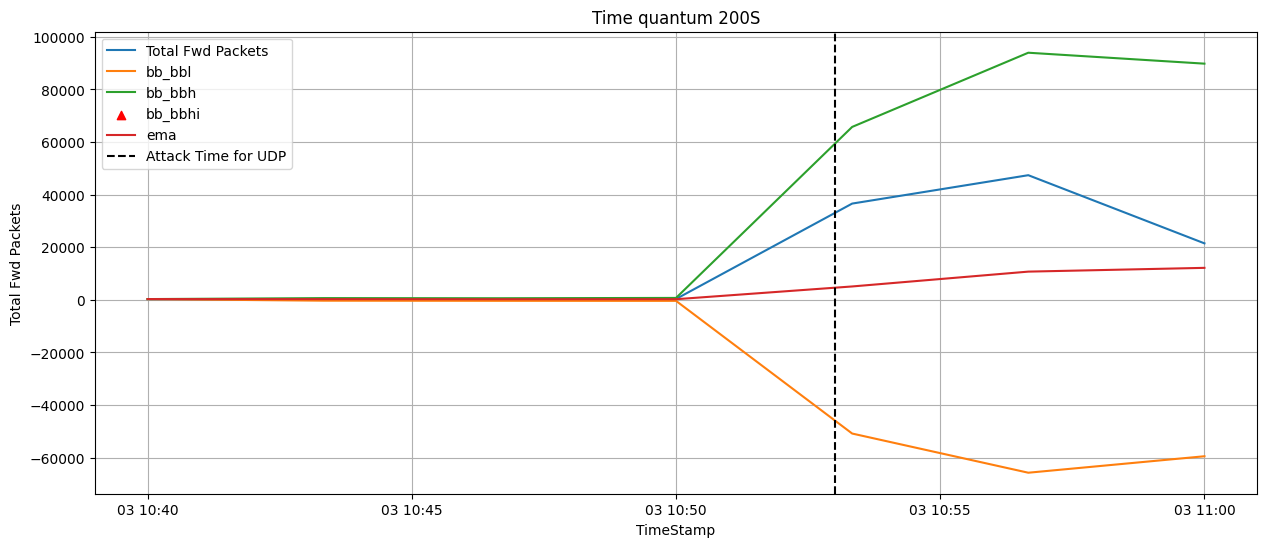

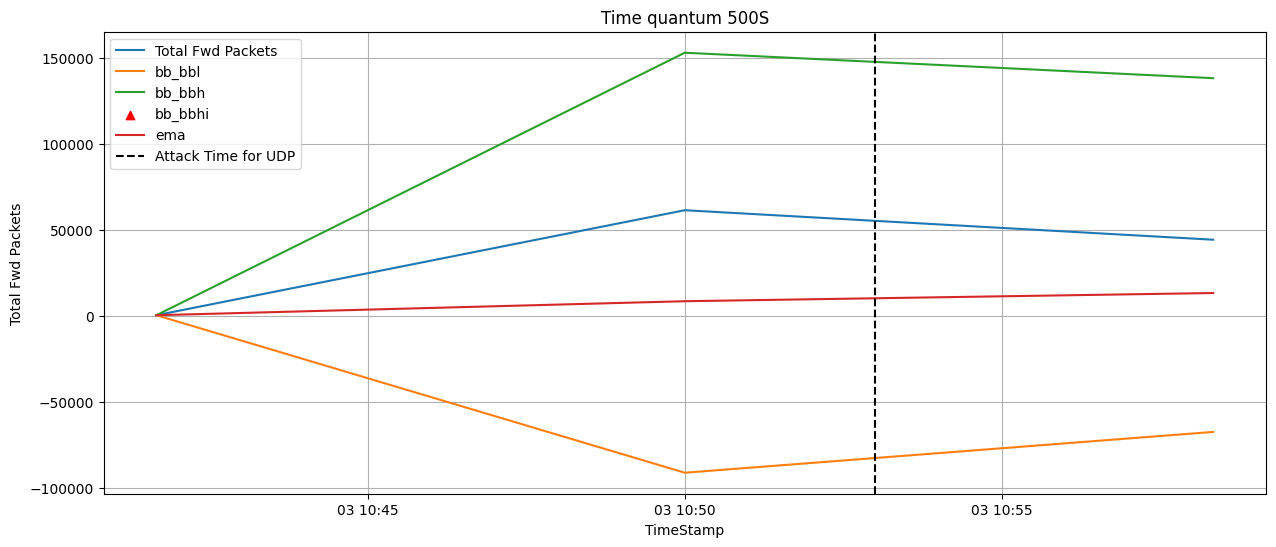

In [ ]:
# Sample time values
time_values = ['1L','2L','3L','4L','5L','8L','10L','20L','30L','40L','50L','60L','100L','200L','300L','400L','500L','1S','2S','3S','4S','5S','10S','15S','20S','40S','50S','100S','110S','200S','500S']  # Example time values in the format 'X{L|S}'
compute_times=[]
for t in time_values:
  new_datetime_t,filtered_df_t,time_taken_t=indicator_computation(df_filtered_grouped,t,col_name_proxies={'close':' Total Fwd Packets','open':'open','high':'high','low':'low'})
  plotter(filtered_df_t,['bb_bbl','bb_bbh','bb_bbhi','ema'],new_datetime_t,title=f"Time quantum {t}",col_name_proxies={'close':' Total Fwd Packets','open':'open','high':'high','low':'low'})
  compute_times.append(time_taken_t)

In [ ]:
# Convert time values to microseconds for better visualization
time_values_micro = [convert_to_milli(val) for val in time_values]
log_time_values = [np.log(np.log(val)) for val in time_values_micro]
# Calculate EWMA with alpha=0.1
ewma_values = pd.Series(log_time_values).ewm(alpha=0.7).mean()/2

# Create the Plotly figure
fig = go.Figure()

# Add the scatter plot with both markers and lines
fig.add_trace(go.Scatter(x=ewma_values, y=compute_times, mode='lines+markers',
                         marker=dict(symbol='circle', size=8),
                         name='EWMA (alpha=0.1)',
                         text=time_values  # Use time_values as text labels
                         ))

# Set layout
fig.update_layout(title='Compute Time vs. Time Quantum',
                  xaxis_title='Time Values ',
                  yaxis_title='Compute Time (seconds)',
                  showlegend=True,
                  plot_bgcolor='white')

# Show the plot
fig.show()

<ipython-input-28-f71dc66298f7>:3: RuntimeWarning: divide by zero encountered in log
  log_time_values = [np.log(np.log(val)) for val in time_values_micro]


#### Indicator Testing

##### prep df

In [ ]:
dfyo_1S = df_filtered_grouped[[' Total Fwd Packets']].resample('1S').sum()
dfyo_1S.rename(columns={' Total Fwd Packets': 'close'}, inplace=True)
dfyo_500L = df_filtered_grouped[[' Total Fwd Packets']].resample('500L').sum()
dfyo_ohlc=resample_to_ohlc(dfyo_500L,'1S')
dfyo_500L.rename(columns={' Total Fwd Packets': 'close'}, inplace=True)

In [ ]:
# df_filtered_grouped[[' Total Fwd Packets']]

In [ ]:
# dfyo_500L

In [ ]:
# Plotting candlestick chart with Plotly
fig = go.Figure(data=[go.Candlestick(x=dfyo_ohlc.index,
                open=dfyo_ohlc['open'],
                high=dfyo_ohlc['high'],
                low=dfyo_ohlc['low'],
                close=dfyo_ohlc['close'])])

fig.show()

In [ ]:
dfyo_1S
# # Calculate the mean and standard deviation of 'Total Fwd Packets'
mean_packets = dfyo_1S['close'].mean()
std_packets = dfyo_1S['close'].std()
# Retrieve the date from the original timestamp

# Create a new datetime object with the given time (9:08:11)
# Define a threshold based on the mean and standard deviation (e.g., 3 standard deviations away from the mean)
threshold = mean_packets + 3 * std_packets

# Filter out the outliers
# filtered_df = dfyo_1S[dfyo_1S['close'] < threshold]
filtered_df=dfyo_1S
date_part = filtered_df[filtered_df.index.time >= pd.to_datetime('10:52').time()].index[0].date()
new_datetime = pd.to_datetime(str(date_part) + ' 10:52:00')
attack_instant = new_datetime

ema=ta.trend.EMAIndicator(filtered_df['close'],fillna=True)
ema_o=ta.trend.EMAIndicator(dfyo_ohlc['open'],fillna=True)
ema_h=ta.trend.EMAIndicator(dfyo_ohlc['high'],fillna=True)
ema_l=ta.trend.EMAIndicator(dfyo_ohlc['low'],fillna=True)
ema_c=ta.trend.EMAIndicator(dfyo_ohlc['close'],fillna=True)

filtered_df['ema']=ema.ema_indicator()
dfyo_ohlc['ema_o']=ema_o.ema_indicator()
dfyo_ohlc['ema_h']=ema_h.ema_indicator()
dfyo_ohlc['ema_l']=ema_l.ema_indicator()
dfyo_ohlc['ema_c']=ema_c.ema_indicator()


filtered_df['ewma'] = filtered_df['close'].ewm(alpha=0.3).mean()
dfyo_ohlc['ewma_o'] = dfyo_ohlc['open'].ewm(alpha=0.3).mean()
dfyo_ohlc['ewma_h'] = dfyo_ohlc['high'].ewm(alpha=0.3).mean()
dfyo_ohlc['ewma_l'] = dfyo_ohlc['low'].ewm(alpha=0.3).mean()
dfyo_ohlc['ewma_c'] = dfyo_ohlc['close'].ewm(alpha=0.3).mean()



In [ ]:
plotter(filtered_df,['ewma'],new_datetime,plotly=True)

##### non financial

In [ ]:
def time_series_to_distribution(time_series):
    """
    Convert a time series into a dictionary where unique values are keys and their counts are values.

    Parameters:
    time_series (numpy.ndarray): The input time series.

    Returns:
    dict: A dictionary where unique values are keys and their counts are values.
    """
    unique_values, counts = np.unique(time_series, return_counts=True)
    distribution_dict = dict(zip(unique_values, counts))
    return distribution_dict

def kl_divergence(distribution1, distribution2):
    """
    Compute the Kullback-Leibler divergence between two distributions.

    Parameters:
    distribution1 (dict): The first distribution dictionary.
    distribution2 (dict): The second distribution dictionary.

    Returns:
    float: The KL divergence between the two distributions.
    """
    kl_div = 0.0
    total1 = sum(distribution1.values())
    total2 = sum(distribution2.values())

    for value, count1 in distribution1.items():
        count2 = distribution2.get(value, 0)  # Get count of value in distribution2, default to 0 if not found
        if count2 > 0:
            p = count1 / total1
            q = count2 / total2
            kl_div += p * np.log(p / q)

    return kl_div

In [ ]:
compute_non = {}

total_cv = 0
total_skew = 0
total_kurt = 0
total_entropy = 0
total_rs = 0
total_reg = 0
total_kl = 0
over = 10




for ij in tqdm(range(over)):
  #one window parameters
  rolling_mean = []
  rolling_coef_variation = []
  rolling_skewness_coef = []
  rolling_kurtosis_coef = []
  rolling_entropy_val = []
  rolling_hurst_rs = []
  rolling_hurst_dfa = []

  #two window parameters
  rolling_corr_coef = []
  rolling_autoreg_coef = []
  rolling_kl_div = []
  lookback=300
  for i in range(len(filtered_df)):
    current_series = filtered_df.iloc[max(0, i - (lookback-1)) : i + 1]['close']
    prev_series = filtered_df.iloc[max(0, i - (lookback)) : i]['close']

    #one window
    start = datetime.now()
    if(max(0,i-(lookback-1))==0):
      coef_variation=None
    else:
      coef_variation = np.var(current_series)
    rolling_coef_variation.append(coef_variation)
    end = datetime.now()
    total_cv += (end - start).total_seconds() * 10**6

    #one window
    start = datetime.now()
    if(max(0,i-(lookback-1))==0):
      skewness_coef=None
    else:
      skewness_coef = skew(current_series)
    rolling_skewness_coef.append(skewness_coef)
    end = datetime.now()
    total_skew += (end - start).total_seconds() * 10**6


    #one window
    start = datetime.now()
    if(max(0,i-(lookback-1))==0):
      kurtosis_coef=None
    else:
      kurtosis_coef = kurtosis(current_series)
    rolling_kurtosis_coef.append(kurtosis_coef)
    end = datetime.now()
    total_kurt += (end - start).total_seconds() * 10**6

    #one window
    start = datetime.now()
    if(max(0,i-(lookback-1))==0):
      entropy_val=None
    else:
      entropy_val = entropy(current_series , base = 2)
    rolling_entropy_val.append(entropy_val)
    end = datetime.now()
    total_entropy += (end - start).total_seconds() * 10**6

    start = datetime.now()
    hurst_rs = 0
    if i >= lookback:
      try:
        hurst_rs = compute_Hc(current_series)[0]
      except:
        pass
      rolling_hurst_rs.append(hurst_rs)

    if i <lookback:
      rolling_hurst_rs.append(None)
    end = datetime.now()
    total_rs += (end - start).total_seconds() * 10**6

    start = datetime.now()
    num = np.sum(current_series[:-1] ** 2)
    den = (np.sum(current_series[:-1] * current_series[1:]))
    if den == 0:
      autoreg_coef = 0
    else :
      autoreg_coef =  num / den
    rolling_autoreg_coef.append(autoreg_coef)

    end = datetime.now()
    total_reg += (end - start).total_seconds() * 10**6


    start = datetime.now()
    kl_div = kl_divergence(time_series_to_distribution(current_series), time_series_to_distribution(prev_series))
    rolling_kl_div.append(kl_div)
    end = datetime.now()
    total_kl += (end - start).total_seconds() * 10**6

compute_non["cv"] = total_cv / over
compute_non["skew"]= total_skew / over
compute_non["kurt"]= total_kurt / over
compute_non["entropy"]= total_entropy / over
compute_non["hurst(r/s)"]= total_rs / over
compute_non["autoregressive coef."]= total_reg / over
compute_non["kl divergence"]= total_kl / over




#one window parameter
filtered_df["coef_variation"] = rolling_coef_variation
# filtered_df["coef_variation_pure"] = (filtered_df["coef_variation"]>6000)

filtered_df["skewness_coef"] = rolling_skewness_coef
filtered_df["skewness_coef_pure"] = (filtered_df["skewness_coef"]>11.5)


filtered_df["kurtosis_coef"] = rolling_kurtosis_coef
filtered_df["kurtosis_coef_pure"] = (filtered_df["kurtosis_coef"]>150)

filtered_df["entropy_val"] = rolling_entropy_val
# filtered_df["entropy_val_pure"] = rolling_entropy_val

filtered_df["hurst_rs"] = rolling_hurst_rs
filtered_df["hurst_rs_pure"] = (filtered_df["hurst_rs"]>0.5)

#two window parameter
filtered_df["autoreg_coef"] = rolling_autoreg_coef
filtered_df["kl_div"] = rolling_kl_div




100%|██████████| 10/10 [01:20<00:00,  8.03s/it]


In [ ]:
for key, value in compute_non.items():
  print(f"{key}: {value}")


# #one window parameters
# plotter(filtered_df,["coef_variation"],attack_instant,double_plot=False,plotly=True).show()
# # plotter(filtered_df,["skewness_coef_pure"],attack_instant,double_plot=False,plotly=True).show()
# # plotter(filtered_df,["kurtosis_coef_pure"],attack_instant,double_plot=False,plotly=True).show()
# # plotter(filtered_df,["entropy_val"],attack_instant,double_plot=False,plotly=True).show()
# # plotter(filtered_df,["hurst_rs_pure"],attack_instant,double_plot=False,plotly=True).show()


# # #two window parameter
# # plotter(filtered_df,["corr_coef"],attack_instant,double_plot=False,plotly=True).show()
# cv: 156672.0
# skew: 683370.0
# kurt: 609503.0
# entropy: 61907.0
# hurst(r/s): 3044349.0
# autoregressive coef.: 2060295.0
# kl divergence: 356126.0

indicator_names = list(compute_non.keys())
compute_times_ms = [value / 1000 for value in compute_times.values()]  # Convert microseconds to milliseconds

# Define red color
red_color = 'red'

# Create a bar chart with red color
fig = go.Figure(
    data=[go.Bar(x=indicator_names, y=compute_times_ms, marker_color=red_color)]
)

# Customize the chart layout
fig.update_layout(
    title="Compute Time of Different Strategies (ms)",
    xaxis_title="Strategy",
    yaxis_title="Compute Time (ms)",
    xaxis_tickangle=45,  # Rotate x-axis labels for better readability with many entries
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    ),
    hovermode="x"
)

# Display the chart
fig.show()

cv: 161955.3
skew: 704448.2
kurt: 619225.6
entropy: 61555.8
hurst(r/s): 3103680.1
autoregressive coef.: 2183049.4
kl divergence: 354295.1


In [ ]:
plotter(filtered_df,["autoreg_coef"],attack_instant,double_plot=False,plotly=True).show()
# plotter(filtered_df,["kl_div"],attack_instant,double_plot=False,plotly=True).show()

##### BB

In [ ]:
from datetime import datetime

In [ ]:
start = datetime.now()
indicator_bb = ta.volatility.BollingerBands(filtered_df['close'],window=300,window_dev=5,fillna=True)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")
filtered_df['bb_bbm'] = indicator_bb.bollinger_mavg()
filtered_df['bb_bbh'] = indicator_bb.bollinger_hband()
filtered_df['bb_bbl'] = indicator_bb.bollinger_lband()
filtered_df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
filtered_df['bb_bbhi'] = filtered_df['bb_bbhi'].astype(bool)
filtered_df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()
filtered_df['bb_bbli'] = filtered_df['bb_bbli'].astype(bool)
plotter(filtered_df,['bb_bbh','bb_bbhi'],new_datetime,plotly=True)

Elapsed 3876.0 µs


##### kst

In [ ]:
start = datetime.now()
kst_thing=ta.trend.KSTIndicator(filtered_df['close'],fillna=True,window1=300,window2=300,window3=300,window4=250,nsig=150)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")
filtered_df['kst'] = kst_thing.kst()
filtered_df['kst_diff'] = kst_thing.kst_diff()
filtered_df['kst_pure'] = (filtered_df['kst_diff']>3000)
filtered_df['kst_sig'] = kst_thing.kst_sig()
plotter(filtered_df,['kst_pure'],attack_instant,plotly=True)
# plotter(filtered_df,['bb_bbh','bb_bbhi'],new_datetime)


Elapsed 11725.0 µs


In [ ]:
plotter(filtered_df,['kst_diff'],attack_instant,plotly=True)

##### MACD

In [ ]:
total_time = 0
for i in range(1000):
  start = datetime.now()
  macd_sigs=ta.trend.MACD(close=filtered_df['close'],fillna=False,window_slow=300,window_fast=250,window_sign=100)
  end = datetime.now()
# print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

  total_time += (end - start).total_seconds() * 10**6

print("Elapsed", total_time/1000, "µs")

filtered_df['macd_diff'] = macd_sigs.macd_diff()
filtered_df['macd_pure'] = (filtered_df['macd_diff']>5)

plotter(filtered_df,['macd_pure'],attack_instant,plotly=True).show()
plotter(filtered_df,['macd_diff'],attack_instant,plotly=True).show()

# plotter(filtered_df,['bb_bbh','bb_bbhi'],new_datetime)


Elapsed 671.945 µs


##### RSI

In [ ]:
total_time = 0
for i in range(10000):
  start = datetime.now()
  rsi=ta.momentum.RSIIndicator(close=filtered_df['close'],fillna=False,window=200)
  end = datetime.now()

  total_time += (end - start).total_seconds() * 10**6

print("Elapsed", total_time/10000, "µs")

filtered_df['rsi'] = rsi.rsi()
filtered_df['rsi_pure']=filtered_df['rsi']>55
plotter(filtered_df,['rsi'],attack_instant,plotly=True,col_name_proxies={'close':'close'})
# plotter(filtered_df,['bb_bbh','bb_bbhi'],new_datetime)



Elapsed 2237.9369 µs


##### TSI

In [ ]:
start = datetime.now()
tsi=ta.momentum.TSIIndicator(close=filtered_df['ema'],fillna=False,window_fast=100,window_slow=200)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

filtered_df['tsi'] = tsi.tsi()
filtered_df['tsi_pure'] = filtered_df['tsi']>28

plotter(filtered_df,['tsi_pure'],attack_instant,double_plot=False,plotly=True,col_name_proxies={'close':'ema'})
# plotter(filtered_df,['bb_bbh','bb_bbhi'],new_datetime)
## 0 crossover

Elapsed 8389.0 µs


##### AWSM

In [ ]:
start = datetime.now()
awsm_osc=ta.momentum.awesome_oscillator(dfyo_ohlc['ema_h'],dfyo_ohlc['ema_l'],fillna=False,window1=5*5,window2=34*5)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

dfyo_ohlc['awsm_osc'] = awsm_osc
dfyo_ohlc['awsm_osc_pure'] = (dfyo_ohlc['awsm_osc'] > 0.03) & (dfyo_ohlc['awsm_osc'].shift(1) > 0) & (dfyo_ohlc['awsm_osc'].shift(2) > 0) & (dfyo_ohlc['awsm_osc'].shift(3) < 0)
# col_name_proxies={'close':'ema_c','open':'ema_o','high':'ema_h','low':'ema_l'}
plotter(dfyo_ohlc,['awsm_osc_pure'],attack_instant,double_plot=False,plotly=True)

Elapsed 12549.0 µs


##### Stoch

In [ ]:
start = datetime.now()
stoch=ta.momentum.stoch(dfyo_ohlc['ema_h'],dfyo_ohlc['ema_l'],dfyo_ohlc['ema_c'],window=150,smooth_window=50)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

dfyo_ohlc['stoch'] = stoch
dfyo_ohlc['stoch_pure']=dfyo_ohlc['stoch']>90

col_name_proxies={'close':'ema_c','open':'ema_o','high':'ema_h','low':'ema_l'}
plotter(dfyo_ohlc,['stoch_pure'],attack_instant,plotly=True)

Elapsed 14117.0 µs


##### Stoch_RSI

In [ ]:
start = datetime.now()
stochrsi=ta.momentum.StochRSIIndicator(close=filtered_df['close'], window = 200, smooth1 = 100, smooth2 = 100)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

filtered_df['stochrsi'] = stochrsi.stochrsi()
filtered_df['stochrsi_pure']=(filtered_df['stochrsi']>0.95)
plotter(filtered_df,['stochrsi_pure'],attack_instant,plotly=True,col_name_proxies={'close':'close'})


Elapsed 7447.0 µs


##### RAPD

###### Pseudocode

https://stackoverflow.com/questions/22583391/peak-signal-detection-in-realtime-timeseries-data/43512887#43512887



* Let y be a vector of timeseries data of at least length lag+2
* Let mean() be a function that calculates the mean
* Let std() be a function that calculates the standard deviaton
* Let absolute() be the absolute value function


**Initialize variables**
* set signals to vector 0,...,0 of length of y;    Initialize signal results
* set filteredY to y(1),...,y(lag)                 Initialize filtered series
* set avgFilter to null;                           Initialize average filter
* set stdFilter to null;                           Initialize std. filter
* set avgFilter(lag) to mean(y(1),...,y(lag));     Initialize first value average
* set stdFilter(lag) to std(y(1),...,y(lag));      Initialize first value std.

```c++
for i=lag+1,...,t do
  if absolute(y(i) - avgFilter(i-1)) > threshold*stdFilter(i-1) then
    if y(i) > avgFilter(i-1) then
      set signals(i) to +1;                      Positive signal
    else
      set signals(i) to -1;                      Negative signal
    end
    set filteredY(i) to influence*y(i) + (1-influence)*filteredY(i-1);
  else
    set signals(i) to 0;                         No signal
    set filteredY(i) to y(i);
  end
  set avgFilter(i) to mean(filteredY(i-lag+1),...,filteredY(i));
  set stdFilter(i) to std(filteredY(i-lag+1),...,filteredY(i));
end
```

###### Code

In [ ]:
def thresholding_algo(z, lag, threshold, influence):
    y=z
    if isinstance(z, pd.Series):
          y = z.values
    signals = np.zeros(len(y))
    filteredY = np.array(y)
    avgFilter = [0]*len(y)
    stdFilter = [0]*len(y)
    avgFilter[lag - 1] = np.mean(y[0:lag])
    stdFilter[lag - 1] = np.std(y[0:lag])
    for i in range(lag, len(y)):
        if abs(y[i] - avgFilter[i-1]) > threshold * stdFilter [i-1]:
            if y[i] > avgFilter[i-1]:
                signals[i] = 1
            else:
                signals[i] = -1

            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i-1]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])
        else:
            signals[i] = 0
            filteredY[i] = y[i]
            avgFilter[i] = np.mean(filteredY[(i-lag+1):i+1])
            stdFilter[i] = np.std(filteredY[(i-lag+1):i+1])

    return dict(signals = np.asarray(signals),
                avgFilter = np.asarray(avgFilter),
                stdFilter = np.asarray(stdFilter))

In [ ]:
def efficient_rapd(y, lag, threshold, influence):
    signals = np.zeros(len(y))
    filteredY = np.copy(y)
    avgFilter = [0] * len(y)
    stdFilter = [0] * len(y)

    avgFilter[lag] = np.mean(y[:lag+1])
    stdFilter[lag] = np.std(y[:lag+1])

    for i in range(lag + 1, len(y)):
        avgFilter[i] = (1 - influence) * y[i] + influence * avgFilter[i - 1]
        stdFilter[i] = np.sqrt((1 - influence) * (y[i] - avgFilter[i]) ** 2 + influence * stdFilter[i - 1] ** 2)

        if np.abs(y[i] - avgFilter[i - 1]) > threshold * stdFilter[i - 1]:
            signals[i] = np.sign(y[i] - avgFilter[i - 1])
            filteredY[i] = influence * y[i] + (1 - influence) * filteredY[i - 1]
        else:
            signals[i] = 0
            filteredY[i] = y[i]

    return signals, filteredY

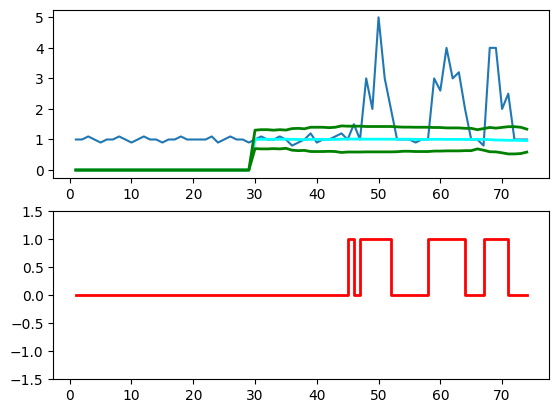

In [ ]:
# Data
y = np.array([1,1,1.1,1,0.9,1,1,1.1,1,0.9,1,1.1,1,1,0.9,1,1,1.1,1,1,1,1,1.1,0.9,1,1.1,1,1,0.9,
       1,1.1,1,1,1.1,1,0.8,0.9,1,1.2,0.9,1,1,1.1,1.2,1,1.5,1,3,2,5,3,2,1,1,1,0.9,1,1,3,
       2.6,4,3,3.2,2,1,1,0.8,4,4,2,2.5,1,1,1])

# Settings: lag = 30, threshold = 5, influence = 0
lag = 30
threshold = 5
influence = 0

# Run algo with settings from above
result = thresholding_algo(y, lag=lag, threshold=threshold, influence=influence)

# Plot result
pylab.subplot(211)
pylab.plot(np.arange(1, len(y)+1), y)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"], color="cyan", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] + threshold * result["stdFilter"], color="green", lw=2)

pylab.plot(np.arange(1, len(y)+1),
           result["avgFilter"] - threshold * result["stdFilter"], color="green", lw=2)

pylab.subplot(212)
pylab.step(np.arange(1, len(y)+1), result["signals"], color="red", lw=2)
pylab.ylim(-1.5, 1.5)
pylab.show()

###### Running

In [ ]:
start = datetime.now()
rapd = thresholding_algo(filtered_df['ema'], lag=200, threshold=5, influence=0.5)
efficient_rapd()
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

filtered_df['rapd'] = (rapd['signals']==1)
plotter(filtered_df,['rapd'],attack_instant,plotly=True)


Elapsed 39437.0 µs


##### Ulcer Index

In [ ]:
start = datetime.now()
ulc_50=ta.volatility.UlcerIndex(close=filtered_df['close'],window=50)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

ulc_80=ta.volatility.UlcerIndex(close=filtered_df['close'],window=80)
ulc_100=ta.volatility.UlcerIndex(close=filtered_df['close'],window=100)
ulc_120=ta.volatility.UlcerIndex(close=filtered_df['close'],window=120)
ulc_150=ta.volatility.UlcerIndex(close=filtered_df['close'],window=150)
ulc_180=ta.volatility.UlcerIndex(close=filtered_df['close'],window=180)
ulc_200=ta.volatility.UlcerIndex(close=filtered_df['close'],window=200)

filtered_df['ulc_50'] = ulc_50.ulcer_index()
filtered_df['ulc_80'] = ulc_80.ulcer_index()
filtered_df['ulc_100'] = ulc_100.ulcer_index()
filtered_df['ulc_120'] = ulc_120.ulcer_index()
filtered_df['ulc_150'] = ulc_150.ulcer_index()
filtered_df['ulc_180'] = ulc_180.ulcer_index()
filtered_df['ulc_200'] = ulc_200.ulcer_index()

sigs=[
    'ulc_50',
    'ulc_80',
    'ulc_100',
    'ulc_120',
    'ulc_150',
    'ulc_180',
    'ulc_200',
]
plotter(filtered_df,sigs,attack_instant,double_plot=True,plotly=True,col_name_proxies={'close':'close'})

Elapsed 13972.0 µs


##### ATR

In [ ]:
start = datetime.now()
atr=ta.volatility.average_true_range(dfyo_ohlc['high'], dfyo_ohlc['low'], dfyo_ohlc['close'], window=200, fillna=False)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

dfyo_ohlc['atr'] = atr
# col_name_proxies={'close':'ema_c','open':'ema_o','high':'ema_h','low':'ema_l'}
plotter(dfyo_ohlc,['atr'],attack_instant,double_plot=True,plotly=True)

Elapsed 11554.0 µs


##### Keltner Channel High Band Indicator (KC)



In [ ]:
start = datetime.now()
kchb=ta.volatility.KeltnerChannel(dfyo_ohlc['ema_h'], dfyo_ohlc['ema_l'], dfyo_ohlc['ema_c'], window=200, window_atr=50, fillna=False, original_version=False)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

dfyo_ohlc['kchb'] = kchb.keltner_channel_hband_indicator()
dfyo_ohlc['kchb_band'] = kchb.keltner_channel_hband()
dfyo_ohlc['kchb_pure'] = (dfyo_ohlc['kchb']>0)


col_name_proxies={'close':'ema_c','open':'ema_o','high':'ema_h','low':'ema_l'}
plotter(dfyo_ohlc,['kchb_pure','kchb','kchb_band'],attack_instant,double_plot=False,plotly=True,col_name_proxies=col_name_proxies)

##### Aroon

In [ ]:
start = datetime.now()
aroon_50=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=50)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

aroon_80=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=80)
aroon_100=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=100)
aroon_120=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=120)
aroon_150=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=150)
aroon_180=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=180)
aroon_200=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=200)

dfyo_ohlc['aroon_50'] = aroon_50.aroon_indicator()
dfyo_ohlc['aroon_80'] = aroon_80.aroon_indicator()
dfyo_ohlc['aroon_100'] = aroon_100.aroon_indicator()
dfyo_ohlc['aroon_120'] = aroon_120.aroon_indicator()
dfyo_ohlc['aroon_150'] = aroon_150.aroon_indicator()
dfyo_ohlc['aroon_180'] = aroon_180.aroon_indicator()
dfyo_ohlc['aroon_200'] = aroon_200.aroon_indicator()

sigs=[
    'aroon_50',
    'aroon_80',
    'aroon_100',
    'aroon_120',
    'aroon_150',
    'aroon_180',
    'aroon_200',
]
plotter(dfyo_ohlc,sigs,attack_instant,double_plot=True,plotly=True,col_name_proxies={'close':'ewma_c'})

Elapsed 28234.0 µs


##### Trix

In [ ]:
start = datetime.now()
trix_50=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=50)
end = datetime.now()
print("Elapsed", (end - start).total_seconds() * 10**6, "µs")

trix_80=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=80)
trix_100=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=100)
trix_120=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=120)
trix_150=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=150)
trix_180=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=180)
trix_200=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=200)

filtered_df['trix_50'] = trix_50.trix()
filtered_df['trix_80'] = trix_80.trix()
filtered_df['trix_100'] = trix_100.trix()
filtered_df['trix_120'] = trix_120.trix()
filtered_df['trix_150'] = trix_150.trix()
filtered_df['trix_180'] = trix_180.trix()
filtered_df['trix_200'] = trix_200.trix()

sigs=[
    'trix_50',
    'trix_80',
    'trix_100',
    'trix_120',
    'trix_150',
    'trix_180',
    'trix_200',
]

filtered_df['trix_50_pure']=(filtered_df['trix_50']>10)
plotter(filtered_df,['trix_50_pure'],attack_instant,plotly=True)

Elapsed 4427.0 µs


##Compute time


In [ ]:


#bb
total_time = 0
for i in range(1000):
  start = datetime.now()
  indicator_bb = ta.volatility.BollingerBands(filtered_df['close'],window=300,window_dev=5,fillna=True)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed BB", total_time/1000, "µs")

#kst
total_time = 0
for i in range(1000):
  start = datetime.now()
  kst_thing=ta.trend.KSTIndicator(filtered_df['close'],fillna=True,window1=300,window2=300,window3=300,window4=250,nsig=150)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed KST", total_time/1000, "µs")


#macd
total_time = 0
for i in range(1000):
  start = datetime.now()
  macd_sigs=ta.trend.MACD(close=filtered_df['close'],fillna=False,window_slow=300,window_fast=250,window_sign=100)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed MACD", total_time/1000, "µs")

#rsi
total_time = 0
for i in range(1000):
  start = datetime.now()
  rsi=ta.momentum.RSIIndicator(close=filtered_df['close'],fillna=False,window=200)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed RSI", total_time/1000, "µs")

#TSI
total_time = 0
for i in range(1000):
  start = datetime.now()
  tsi=ta.momentum.TSIIndicator(close=filtered_df['ema'],fillna=False,window_fast=100,window_slow=200)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed TSI", total_time/1000, "µs")

#AWSM
total_time = 0
for i in range(1000):
  start = datetime.now()
  awsm_osc=ta.momentum.awesome_oscillator(dfyo_ohlc['ema_h'],dfyo_ohlc['ema_l'],fillna=False,window1=5*5,window2=34*5)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed AWSM", total_time/1000, "µs")

#STOCH
total_time = 0
for i in range(1000):
  start = datetime.now()
  stoch=ta.momentum.stoch(dfyo_ohlc['ema_h'],dfyo_ohlc['ema_l'],dfyo_ohlc['ema_c'],window=150,smooth_window=50)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed STOCH", total_time/1000, "µs")

#STOCHRSI
total_time = 0
for i in range(1000):
  start = datetime.now()
  stochrsi=ta.momentum.StochRSIIndicator(close=filtered_df['close'], window = 200, smooth1 = 100, smooth2 = 100)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed STOCHRSI", total_time/1000, "µs")

#RAPD
total_time = 0
for i in range(1000):
  start = datetime.now()
  rapd = thresholding_algo(filtered_df['ema'], lag=200, threshold=5, influence=0.5)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed RAPD", total_time/1000, "µs")

#ULCER INDEX
total_time = 0
for i in range(1000):
  start = datetime.now()
  ulc_200=ta.volatility.UlcerIndex(close=filtered_df['close'],window=200)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed UI", total_time/1000, "µs")

#ATR
total_time = 0
for i in range(1000):
  start = datetime.now()
  atr=ta.volatility.average_true_range(dfyo_ohlc['high'], dfyo_ohlc['low'], dfyo_ohlc['close'], window=200, fillna=False)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed ATR", total_time/1000, "µs")

#kc
total_time = 0
for i in range(1000):
  start = datetime.now()
  kchb=ta.volatility.KeltnerChannel(dfyo_ohlc['ema_h'], dfyo_ohlc['ema_l'], dfyo_ohlc['ema_c'], window=200, window_atr=50, fillna=False, original_version=False)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed KC", total_time/1000, "µs")

#aroon
total_time = 0
for i in range(1000):
  start = datetime.now()
  aroon_200=ta.trend.AroonIndicator(high=dfyo_ohlc['ewma_h'],low=dfyo_ohlc['ewma_l'],window=200)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed AROON", total_time/1000, "µs")

#trix
total_time = 0
for i in range(1000):
  start = datetime.now()
  trix_200=ta.trend.TRIXIndicator(close=filtered_df['ewma'],window=200)
  end = datetime.now()
  total_time += (end - start).total_seconds() * 10**6
print("Elapsed TRIX", total_time/1000, "µs")

Elapsed BB 1963.307 µs
Elapsed BB 7677.42 µs
Elapsed MACD 1783.738 µs
Elapsed RSI 3652.41 µs
Elapsed TSI 1124.045 µs
Elapsed AWSM 749.286 µs
Elapsed STOCH 851.688 µs
Elapsed STOCHRSI 3073.529 µs
Elapsed RAPD 36979.192 µs
Elapsed UI 7635.781 µs
Elapsed ATR 10195.603 µs
Elapsed KC 12025.723 µs
Elapsed AROON 4864.002 µs
Elapsed TRIX 1837.826 µs


In [ ]:
Elapsed BB 1505.885 µs
Elapsed MACD 653.247 µs
Elapsed RSI 2676.591 µs
Elapsed TSI 1704.081 µs
Elapsed AWSM 758.235 µs
Elapsed STOCH 816.385 µs
Elapsed STOCHRSI 3094.561 µs
Elapsed RAPD 35529.51 µs
Elapsed UI 7912.711 µs
Elapsed ATR 10254.947 µs
Elapsed KC 11913.976 µs
Elapsed AROON 4864.93 µs
Elapsed TRIX 1281.16 µs

### Analysis

In [ ]:
import pandas as pd
import numpy as np

def metric_temporal(signals, time_series, attack_instant,alpha=2):
    attack_instant = pd.to_datetime(attack_instant)  # Convert to timestamp if not already
    time_diff_seconds = (time_series - attack_instant).total_seconds()  # Calculate time difference in seconds

    # Count number of signals before attack instant
    signals_before_attack = np.sum(signals[:np.argmax(time_series >= attack_instant)])

    # Count number of signals after attack instant
    signals_after_attack = np.sum(signals[np.argmax(time_series > attack_instant):])
    # print("oi",np.argmax(time_series >= attack_instant) + 1)
    # Weigh signals after attack instant
    weighted_signals = []
    for i, signal_time in enumerate(time_series):
        if ((signal_time > attack_instant) and (signals[i])):
            weight = np.exp((-(signal_time - attack_instant).seconds / 60)/alpha)  # Weight calculation
            weighted_signals.append(signals[i] * weight)

    weighted_signals_sum = np.sum(weighted_signals)
    # print("hey",len(weighted_signals))

    return time_diff_seconds, (signals_before_attack, signals_after_attack, weighted_signals_sum)

# Example usage
signals = [0, 1, 0, 1, 1, 0]
time_series = pd.to_datetime(['2024-04-20 12:00:00', '2024-04-20 12:10:00', '2024-04-20 12:20:00', '2024-04-20 12:30:00', '2024-04-20 12:40:00', '2024-04-20 12:50:00'])
attack_instant = '2024-04-20 12:25:00'

time_diff, metrics = metric_temporal(signals, time_series, attack_instant)
print("Time difference in seconds:", time_diff)
print("Number of signals before attack instant:", metrics[0])
print("Number of signals after attack instant:", metrics[1])
print("Weighted sum of signals after attack instant:", metrics[2])

Time difference in seconds: Index([-1500.0, -900.0, -300.0, 300.0, 900.0, 1500.0], dtype='float64')
Number of signals before attack instant: 1
Number of signals after attack instant: 2
Weighted sum of signals after attack instant: 0.08263808299404664


In [ ]:
date_part = filtered_df[filtered_df.index.time >= pd.to_datetime('10:52').time()].index[0].date()
new_datetime = pd.to_datetime(str(date_part) + ' 10:52:00')
attack_instant = new_datetime

In [ ]:
alpha_vec=[0.01,0.1,0.5,1,2,10]

In [ ]:
indicator_metrics = pd.DataFrame(columns=['indicator_type', 'False Positive Number', 'True Positive Number'] + ['M_' + str(al) for al in alpha_vec])

for k in filtered_df.columns:
    if filtered_df[k].dtype==bool and k!='bb_bbli':
        row_insert = [k]
        for alp in alpha_vec:
            _, metric_vals = metric_temporal(filtered_df[k], filtered_df.index, attack_instant, alpha=alp)
            if(len(row_insert)==1):
              row_insert += metric_vals
            else:
              row_insert += [metric_vals[2]]
        indicator_metrics.loc[len(indicator_metrics)] = row_insert
indicator_metrics

indicator_type  False Positive Number  True Positive Number  \
0  skewness_coef_pure                      1                     2   
1  kurtosis_coef_pure                      1                     2   
2       hurst_rs_pure                      1                    46   
3      hurst_dfa_pure                      0                     0   

         M_0.01     M_0.1     M_0.5       M_1        M_2       M_10  
0  3.713806e-28  0.003280  0.554301  1.052865   1.451101   1.875698  
1  3.713806e-28  0.003280  0.554301  1.052865   1.451101   1.875698  
2  3.123797e-28  0.001776  0.882800  5.604667  15.742132  37.030739  
3  0.000000e+00  0.000000  0.000000  0.000000   0.000000   0.000000

In [ ]:
for k in dfyo_ohlc.columns:
    if dfyo_ohlc[k].dtype==bool and k!='bb_bbli':
        row_insert = [k]
        for alp in alpha_vec:
            _, metric_vals = metric_temporal(dfyo_ohlc[k], dfyo_ohlc.index, attack_instant, alpha=alp)
            if(len(row_insert)==1):
              row_insert += metric_vals
            else:
              row_insert += [metric_vals[2]]
        indicator_metrics.loc[len(indicator_metrics)] = row_insert

In [ ]:
indicator_metrics

indicator_type  False Positive Number  True Positive Number  \
0            macd_pure                      0                    57   
1             rsi_pure                      0                    33   
2             tsi_pure                      0                   142   
3                 rapd                      2                    41   
4   skewness_coef_pure                      1                     2   
5   kurtosis_coef_pure                      1                     2   
6        hurst_rs_pure                      1                    46   
7       hurst_dfa_pure                      0                     0   
8        awsm_osc_pure                      0                     3   
9           stoch_pure                      1                    32   
10           kchb_pure                      0                   127   

           M_0.01         M_0.1     M_0.5        M_1        M_2        M_10  
0   1.098523e-123  3.226986e-12  0.089738   2.182269  11.050015   40.994059  
1    3.123825e-28  2.725549e-03  1.159067   5.045566  12.406665   27.000041  
2    1.149592e-89  8.143349e-09  0.501066   7.058122  29.994169  103.095903  
3    3.851194e-28  1.076550e-02  3.951562  10.652677  19.796575   35.131843  
4    3.713806e-28  3.279543e-03  0.554301   1.052865   1.451101    1.875698  
5    3.713806e-28  3.279543e-03  0.554301   1.052865   1.451101    1.875698  
6    3.123797e-28  1.776175e-03  0.882800   5.604667  15.742132   37.030739  
7    0.000000e+00  0.000000e+00  0.000000   0.000000   0.000000    0.000000  
8    1.114383e-29  1.272640e-03  0.286726   0.665930   1.127263    2.224549  
9    6.110582e-29  3.312466e-03  1.033577   3.441616   9.163742   24.498732  
10   7.273965e-29  9.305710e-03  4.484596  16.145317  40.619408   99.515059

In [ ]:
time_diff, metrics = metric_temporal(signals, time_series, attack_instant)
print("Time difference in seconds:", time_diff)
print("Number of signals before attack instant:", metrics[0])
print("Number of signals after attack instant:", metrics[1])
print("Weighted sum of signals after attack instant:", metrics[2])
    indicator_bb = ta.volatility.BollingerBands(filtered_df['close'],window=300,window_dev=5,fillna=True)
filtered_df['bb_bbm'] = indicator_bb.bollinger_mavg()
filtered_df['bb_bbh'] = indicator_bb.bollinger_hband()
filtered_df['bb_bbl'] = indicator_bb.bollinger_lband()
filtered_df['bb_bbhi'] = indicator_bb.bollinger_hband_indicator()
filtered_df['bb_bbhi'] = filtered_df['bb_bbhi'].astype(bool)
filtered_df['bb_bbli'] = indicator_bb.bollinger_lband_indicator()
filtered_df['bb_bbli'] = filtered_df['bb_bbli'].astype(bool)
plotter(filtered_df,['bb_bbh','bb_bbhi'],new_datetime,plotly=True)

IndentationError: unexpected indent (<ipython-input-85-24d464876716>, line 6)